In [57]:
from google.colab import drive
drive.mount('/content/drive/')
from pandas import DataFrame, Series
import pandas as pd
import glob
import re
from tqdm import tqdm
import torchaudio
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle
import os
import glob
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input 
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from keras.models import load_model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
train_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/test_df.csv")

In [59]:
belt = train_df[train_df['technique'] == 'belt'].iloc[100]
straight = train_df[train_df['technique'] == 'straight'].iloc[100]
vibrato = train_df[train_df['technique'] == 'vibrato'].iloc[100]
vocal_fry = train_df[train_df['technique'] == 'vocal_fry'].iloc[100]

belt = librosa.load(os.path.join('.',belt["path"] ), sr = 44100)
straight = librosa.load(os.path.join('.',straight["path"] ), sr = 44100)
vibrato = librosa.load(os.path.join('.',vibrato["path"] ), sr = 44100)
vocal_fry = librosa.load(os.path.join('.',vocal_fry["path"] ), sr = 44100)

In [60]:
mean = np.mean([belt[0][:406454], straight[0][:406454], vibrato[0][:406454], vocal_fry[0][:406454]])
std = np.std([belt[0][:406454], straight[0][:406454], vibrato[0][:406454], vocal_fry[0][:406454]])

In [61]:
def make_audio(belt):
  j = 2
  belt_audio = []
  while (j+1)*0.4 < (len(belt[0])/44100):
    belt_audio.append(belt[0][int(j*0.4*44100) : int((j+1)*0.4*44100)]) # 0.4초씩 nonoverlapping하게 자르기
    j += 1
  return belt_audio

belt_audio = make_audio(belt)
straight_audio = make_audio(straight)
vibrato_audio = make_audio(vibrato)
vocal_fry_audio = make_audio(vocal_fry)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def standardize(data):
  new_data = []
  for i in range(len(data)):
    new_data.append((data[i] - mean)/std)
  return new_data
belt_std = standardize(belt_audio)
straight_std = standardize(straight_audio)
vibrato_std = standardize(vibrato_audio)
vocal_fry_std = standardize(vocal_fry_audio)
# belt_std = scaler.fit_transform(belt_audio)
# straight_std = scaler.fit_transform(straight_audio)
# vibrato_std = scaler.fit_transform(vibrato_audio)
# vocal_fry_std = scaler.fit_transform(vocal_fry_audio)

In [63]:
print("before standardize", belt_audio[0][:10])
print("after standardize", belt_std[0][:10])

before standardize [-0.00723267 -0.00875854 -0.01043701 -0.01296997 -0.01599121 -0.01855469
 -0.02099609 -0.02209473 -0.02261353 -0.02246094]
after standardize [-0.12020128 -0.14550711 -0.17334354 -0.21535124 -0.26545683 -0.30797064
 -0.34846    -0.36668018 -0.37528417 -0.3727536 ]


In [64]:
def show_wave(name, data):
  plt.figure(figsize=(16, 2))
  plt.title(name)
  plt.plot(data)
  plt.ylim((-1, 1))
  plt.show()

In [65]:
def show_spec(data, name, x_axis = 'time', y_axis = "mel"):
  librosa.display.specshow(data, sr = 44100, x_axis = x_axis)
  plt.title(name)
  plt.tight_layout()
  plt.show() 

In [66]:
technique_data = [belt_audio, straight_audio, vibrato_audio, vocal_fry_audio]
std_data = [belt_std, straight_std, vibrato_std, vocal_fry_std]

# Wave

In [ ]:
def show_wave_datas(idx):
  show_wave(name = 'belt', data = belt_audio[idx])
  show_wave(name = 'straight', data = straight_audio[idx])
  show_wave(name = 'vibrato_audio', data = vibrato_audio[idx])
  show_wave(name = 'vocal_fry', data = vocal_fry_audio[idx])

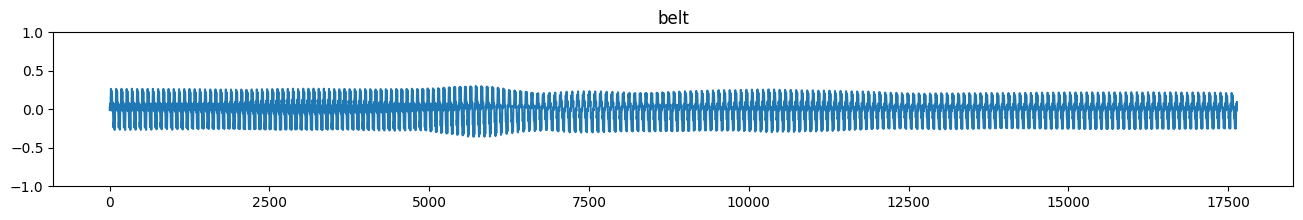

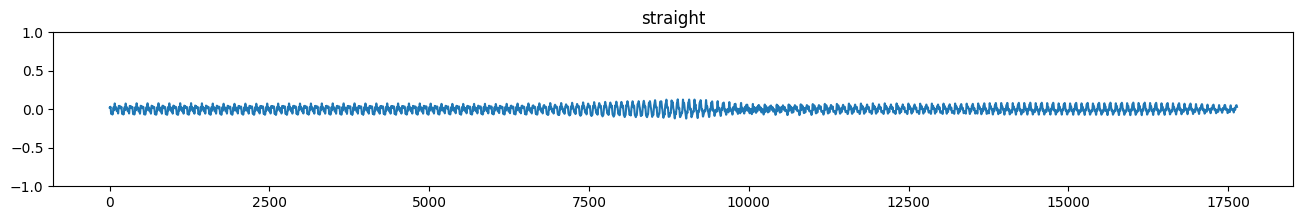

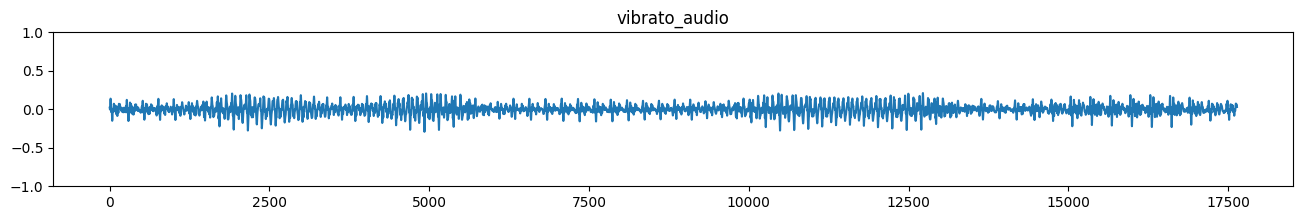

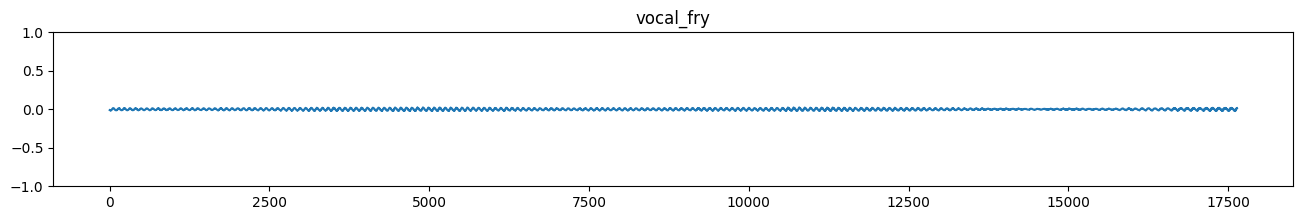

In [ ]:
show_wave_datas(12)

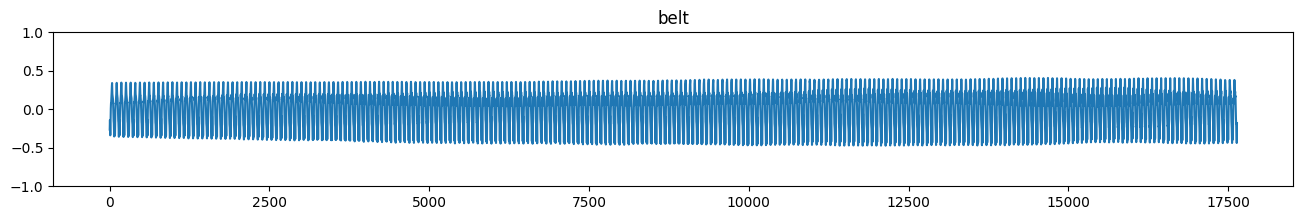

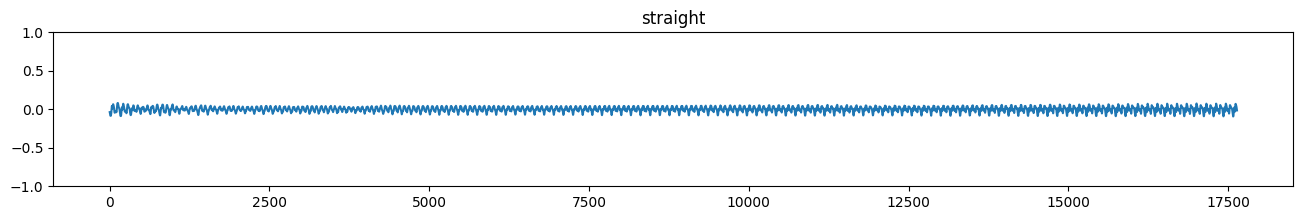

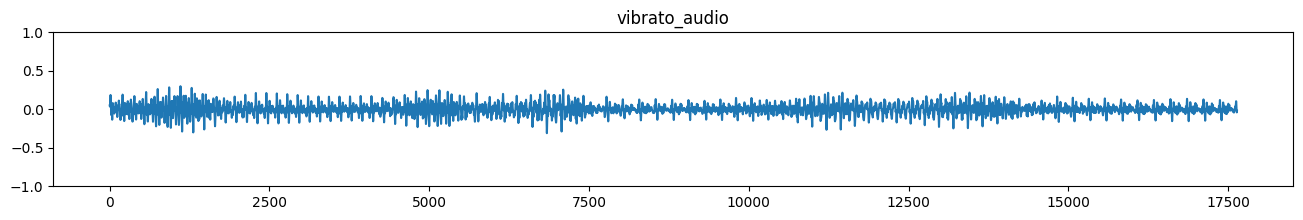

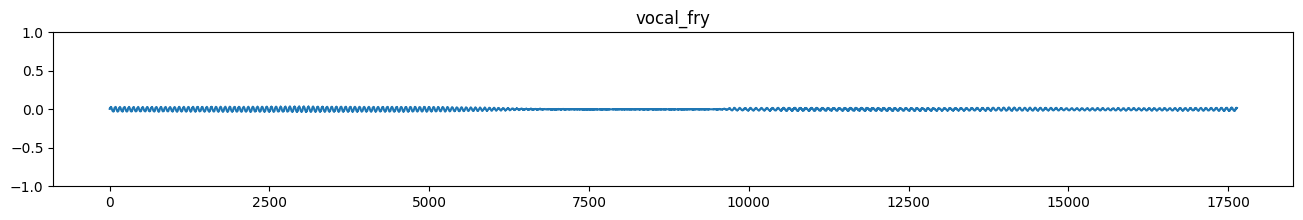

In [ ]:
show_wave_datas(10)

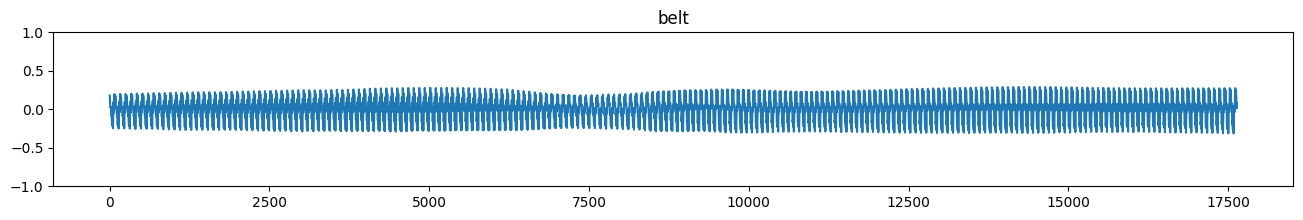

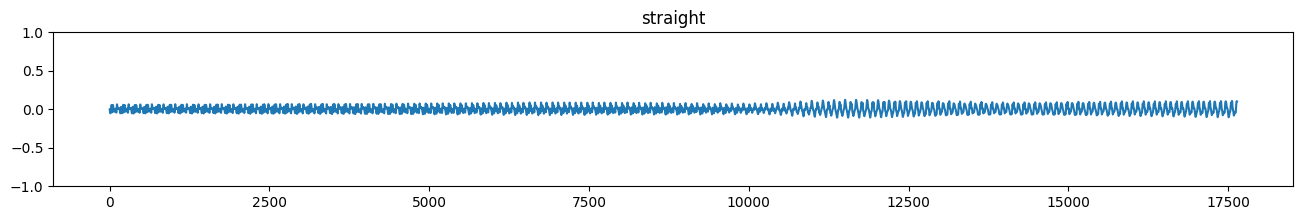

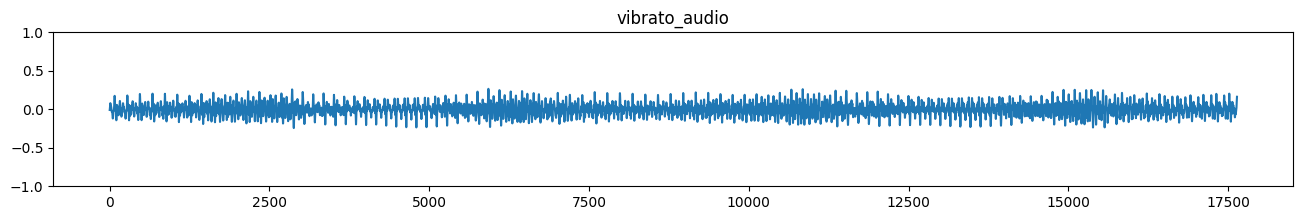

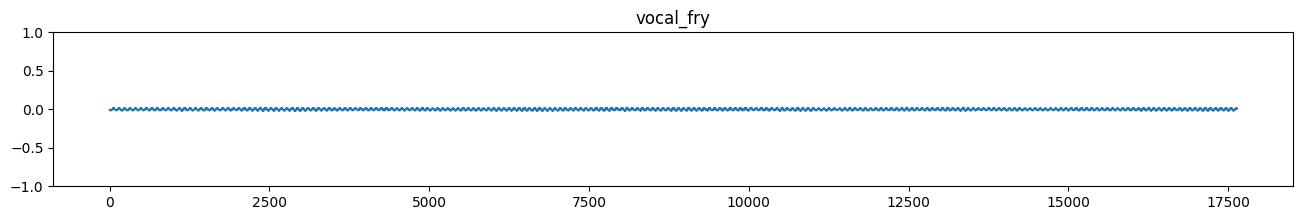

In [ ]:
show_wave_datas(8)

### 1) before & after standardization

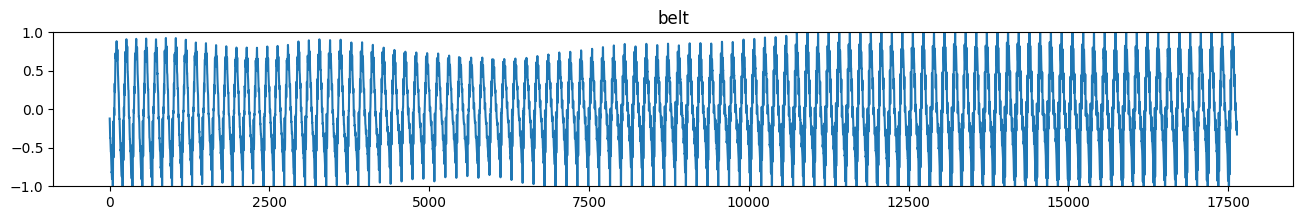

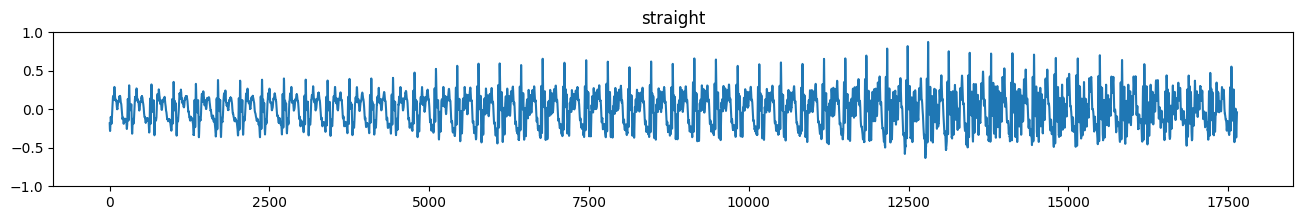

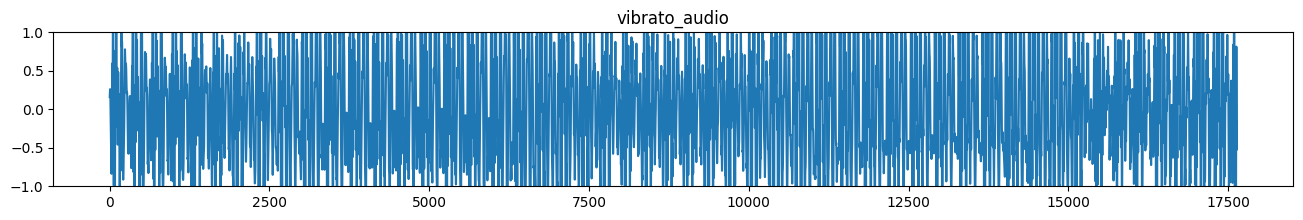

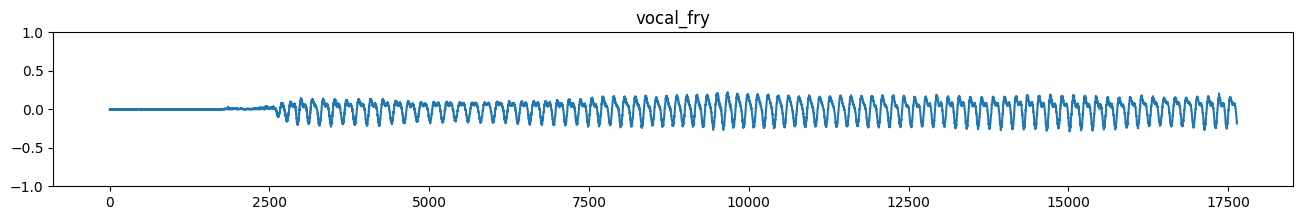

In [ ]:
def show_stds_waves(idx):
  show_wave(name = 'belt', data = belt_std[idx])
  show_wave(name = 'straight', data = straight_std[idx])
  show_wave(name = 'vibrato_audio', data = vibrato_std[idx])
  show_wave(name = 'vocal_fry', data = vocal_fry_std[idx])
show_stds_waves(0)

In [ ]:
def cmp_std_datas(data,std_data, idx, name):
  show_wave(name = name, data = data[idx])
  show_wave(name = "standardized " + name, data = std_data[idx])

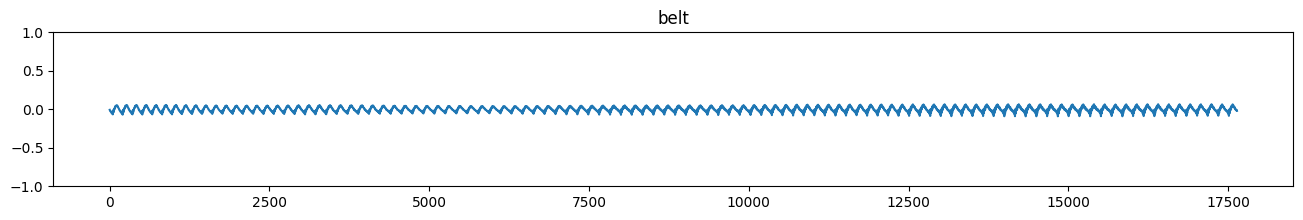

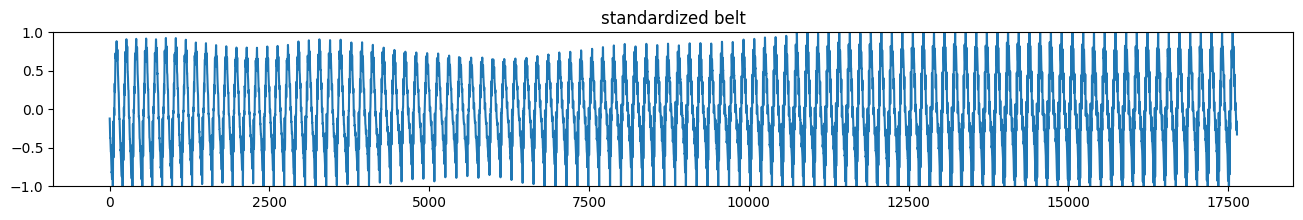

In [ ]:
cmp_std_datas(belt_audio, belt_std, 0, name = "belt")

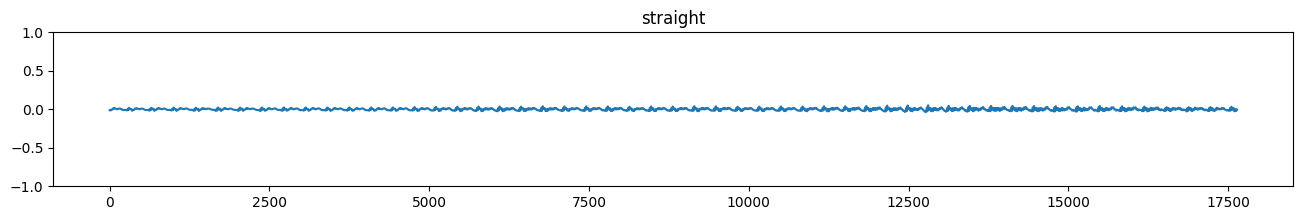

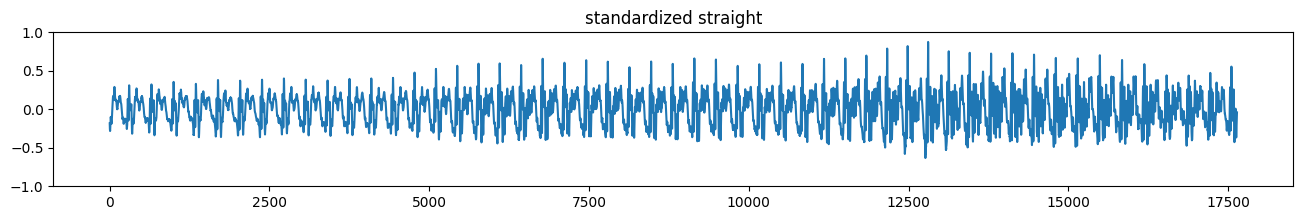

In [ ]:
cmp_std_datas(straight_audio, straight_std, 0, name = "straight")

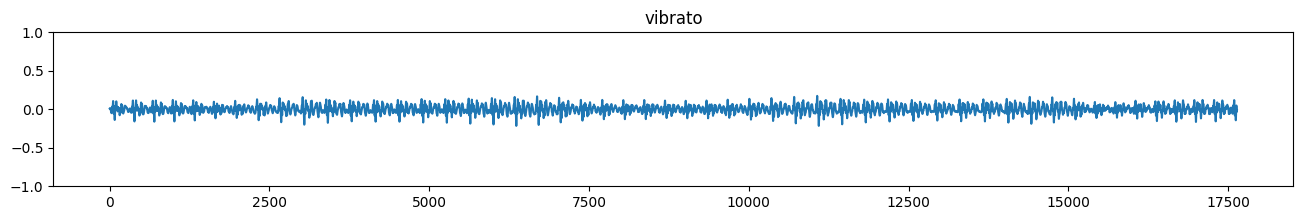

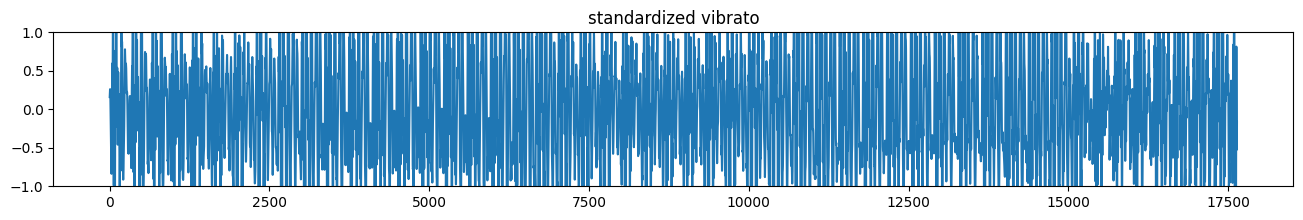

In [ ]:
cmp_std_datas(vibrato_audio, vibrato_std, 0, name = "vibrato")

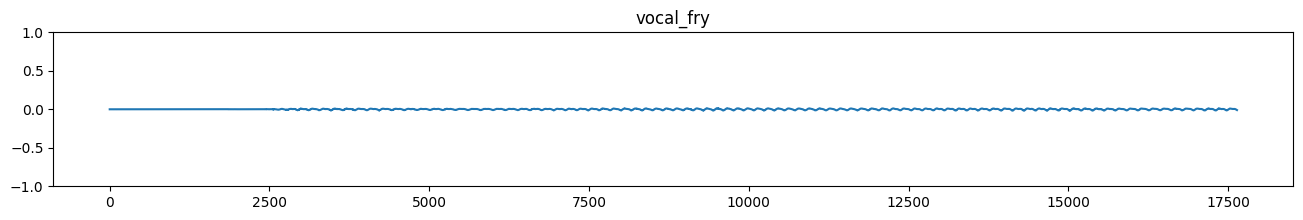

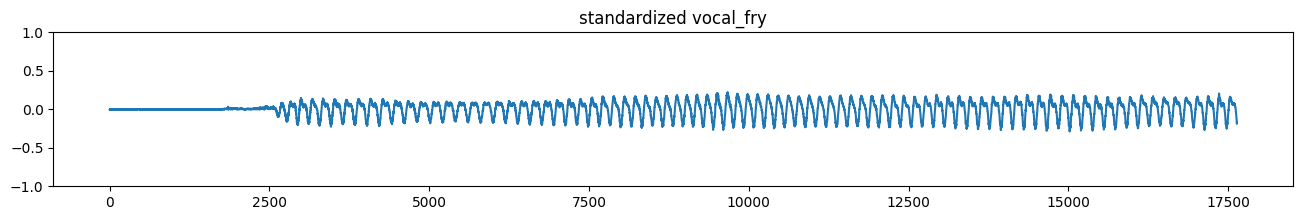

In [ ]:
cmp_std_datas(vocal_fry_audio, vocal_fry_std, 0, name = "vocal_fry")

### 2) vibrato time stretch

In [ ]:
vibrato_1 = librosa.effects.time_stretch(vibrato[0], rate = 1.5)
vibrato_2 = librosa.effects.time_stretch(vibrato[0], rate = 2.0)

vibrato_1_audio = make_audio([vibrato_1])
vibrato_2_audio = make_audio([vibrato_2])

In [ ]:
def show_wave_vibrato_rates(idx):
  show_wave(name = "1.0 rate vicrato", data = vibrato_audio[idx])
  show_wave(name = "1.5 rate vicrato", data = vibrato_1_audio[idx])
  show_wave(name = "2.0 rate vicrato", data = vibrato_2_audio[idx])

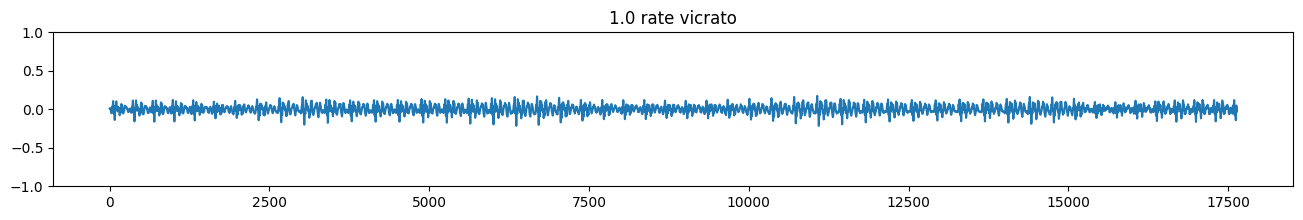

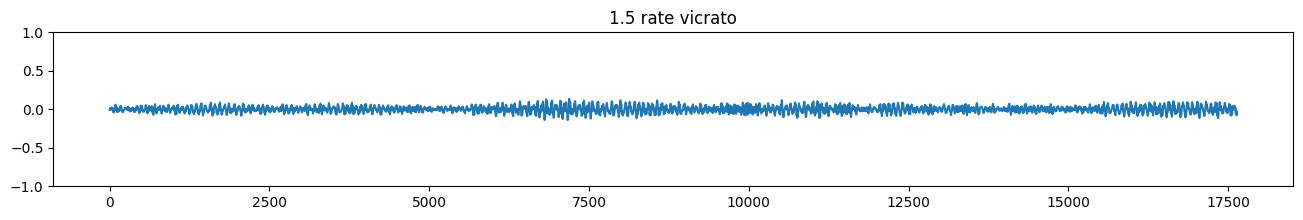

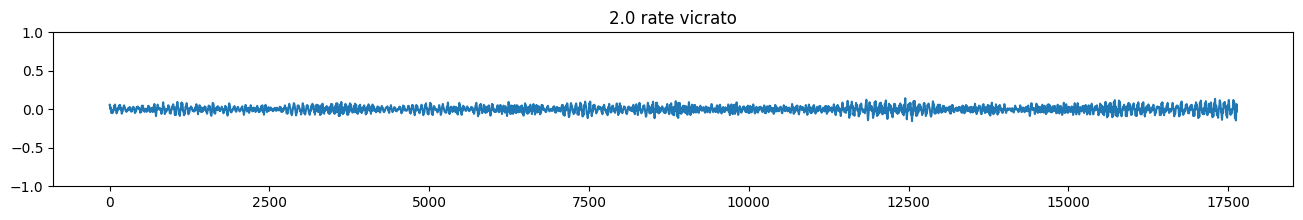

In [ ]:
show_wave_vibrato_rates(0)

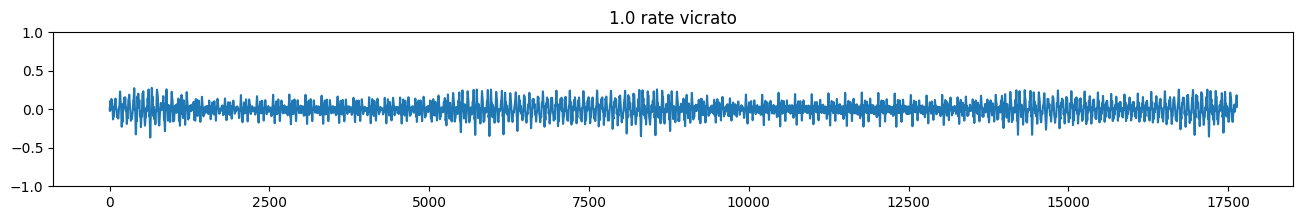

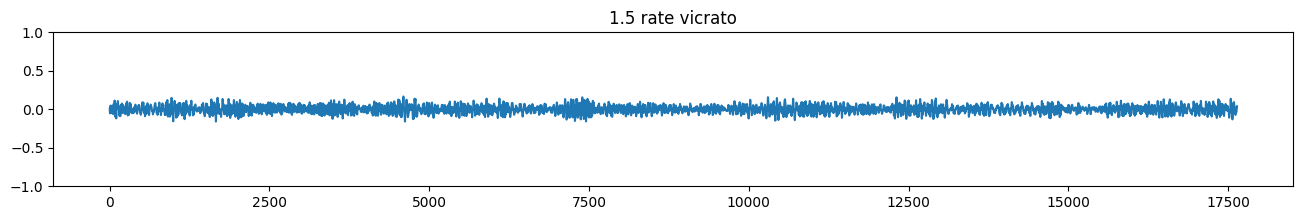

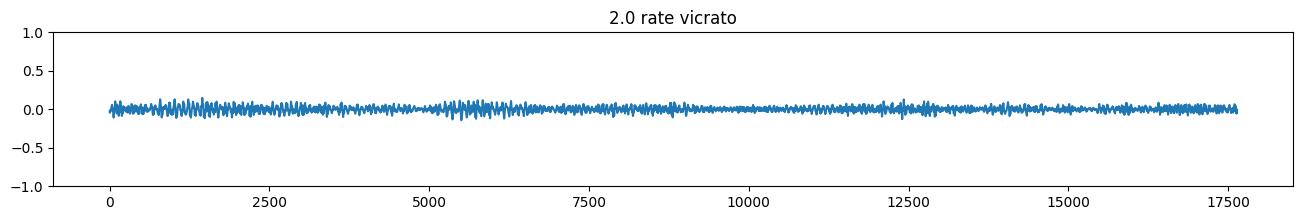

In [ ]:
show_wave_vibrato_rates(5)

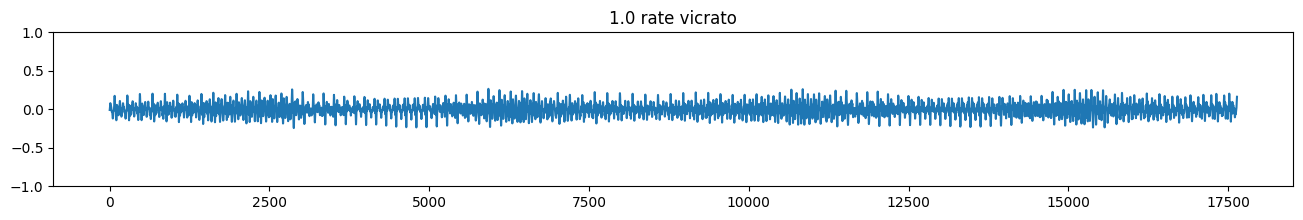

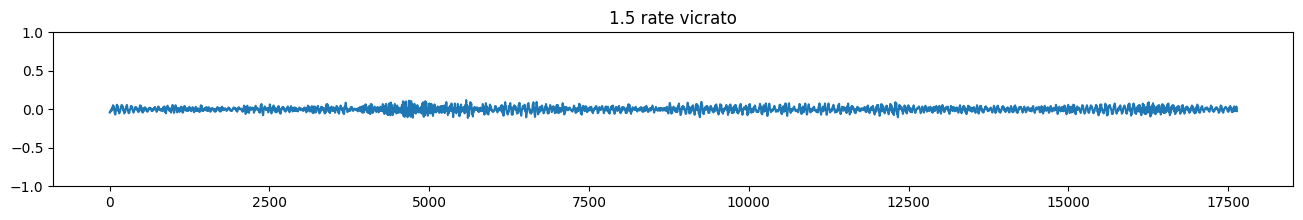

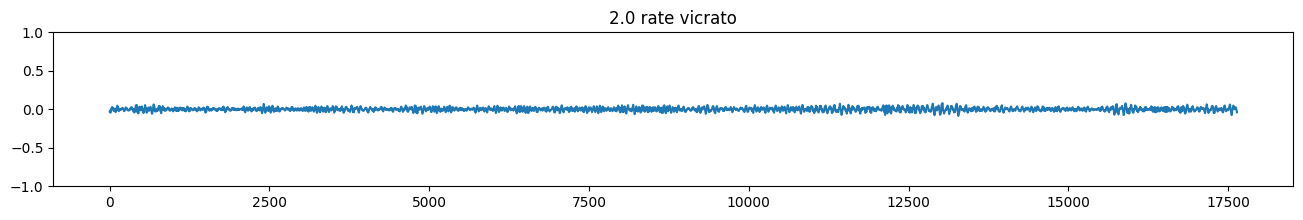

In [ ]:
show_wave_vibrato_rates(8)

# Augmentation

In [ ]:
def show_aug(audio, audio_aug,idx, name, aug):
  show_wave(data=audio[idx], name=name)
  show_wave(data=audio_aug[idx], name=name + "_" + aug)

### 1) Noise
+ 0.2의 비율은 아주 잘못된 거였음 하하,,

In [ ]:
def make_noise(audio, noise_rate):
  noise = np.random.randn(len(audio[0]))
  noise = (noise - min(noise)) / (max(noise) - min(noise))
  audio_noise = audio + noise_rate* noise
  print(audio[0][3], audio_noise[0][3])
  return audio_noise
belt_noise = make_noise(belt_audio, 0.01)
straight_noise = make_noise(straight_audio, 0.01)
vibrato_noise = make_noise(vibrato_audio, 0.01)
vocal_fry_noise = make_noise(vocal_fry_audio, 0.01)

-0.012969971 -0.010094036399525741
-0.015655518 -0.01095016443048518
0.013366699 0.018621803581371835
0.0 0.004045107510810563


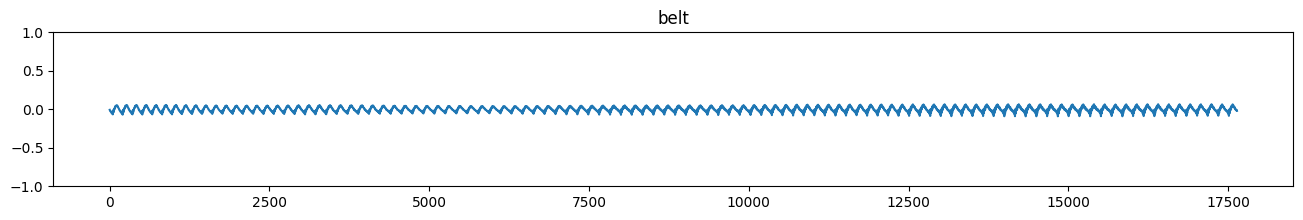

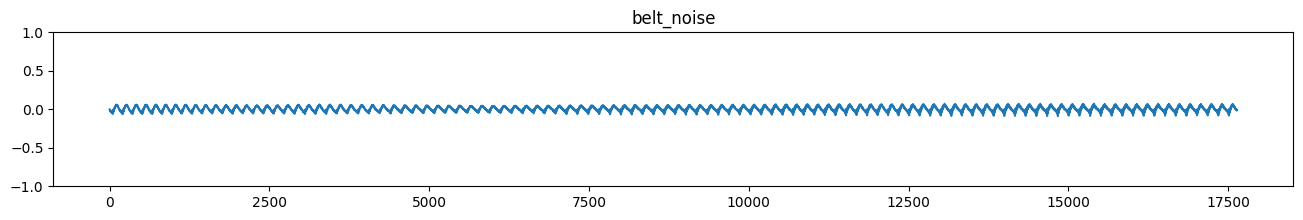

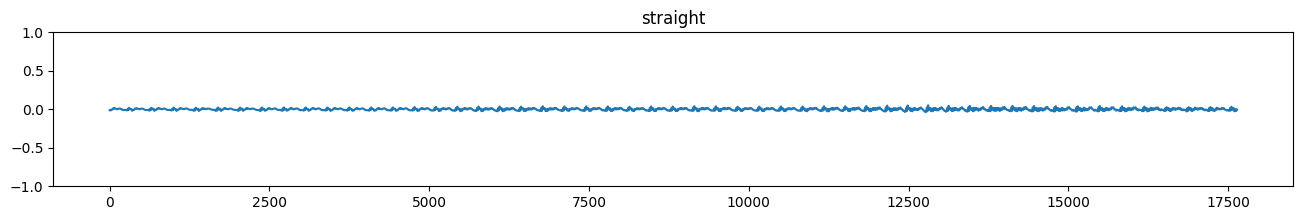

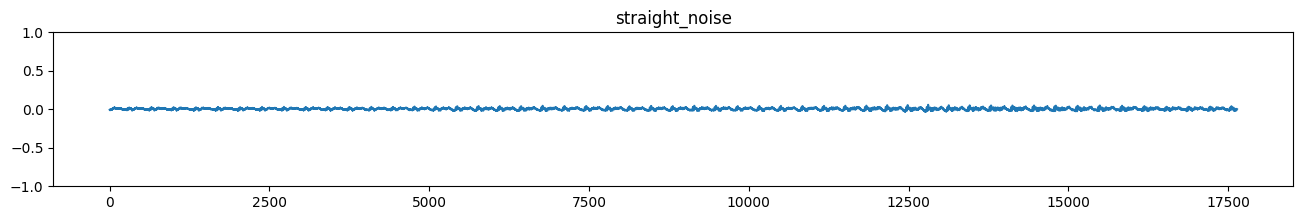

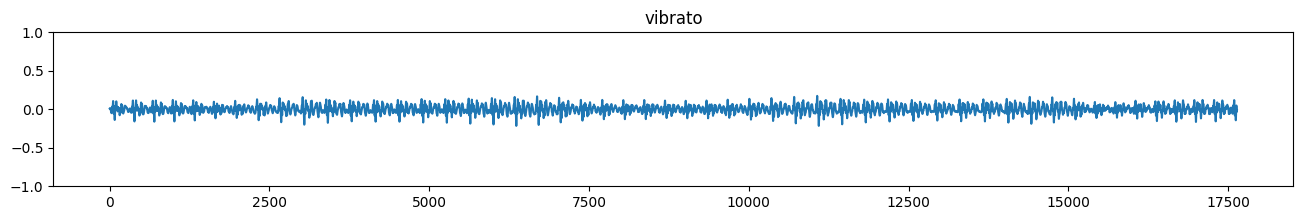

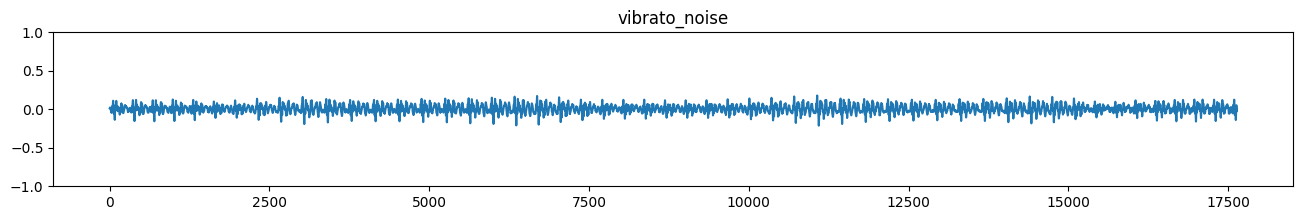

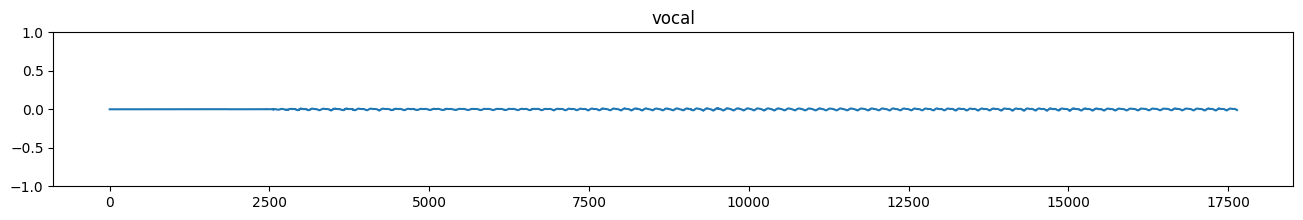

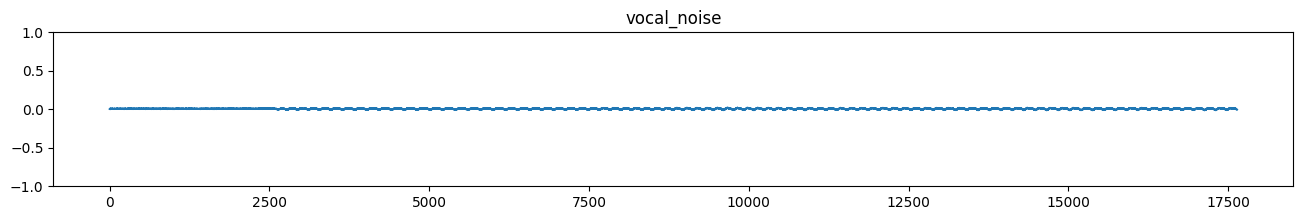

In [ ]:
show_aug(belt_audio, belt_noise, 0, name = 'belt', aug = "noise")
show_aug(straight_audio, straight_noise, 0,name = 'straight', aug = "noise")
show_aug(vibrato_audio, vibrato_noise, 0, name = 'vibrato', aug = "noise")
show_aug(vocal_fry_audio, vocal_fry_noise, 0, name = 'vocal', aug = "noise")

In [ ]:
''' 0.2 noise rate인데 이래서 성능이 그렇게 그지같이 나왔었구나,,,,,,
show_aug(belt_audio, belt_noise, 0, name = 'belt', aug = "noise")
show_aug(straight_audio, straight_noise, 0,name = 'straight', aug = "noise")
show_aug(vibrato_audio, vibrato_noise, 0, name = 'vibrato', aug = "noise")
show_aug(vocal_fry_audio, vocal_fry_noise, 0, name = 'vocal', aug = "noise")
'''

' 0.2 noise rate인데 이래서 성능이 그렇게 그지같이 나왔었구나,,,,,,\nshow_aug(belt_audio, belt_noise, 0, name = \'belt\', aug = "noise")\nshow_aug(straight_audio, straight_noise, 0,name = \'straight\', aug = "noise")\nshow_aug(vibrato_audio, vibrato_noise, 0, name = \'vibrato\', aug = "noise")\nshow_aug(vocal_fry_audio, vocal_fry_noise, 0, name = \'vocal\', aug = "noise")\n'

## 2) pitch shift

In [ ]:
def make_pitch(audio, pitch):
  audio_pitch_shift = []
  for i in tqdm(range(len(audio))):
      audio_pitch_shift.append(librosa.effects.pitch_shift(audio[i], sr=44100, n_steps=pitch))
  return audio_pitch_shift
belt_pitch = make_pitch(belt_audio, 4)
straight_pitch = make_pitch(straight_audio, 4)
vibrato_pitch = make_pitch(vibrato_audio, 4)
vocal_fry_pitch = make_pitch(vocal_fry_audio, 4)

100%|██████████| 21/21 [00:00<00:00, 61.06it/s]


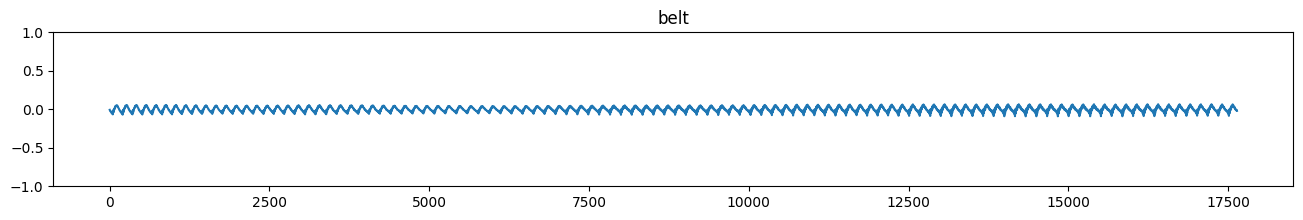

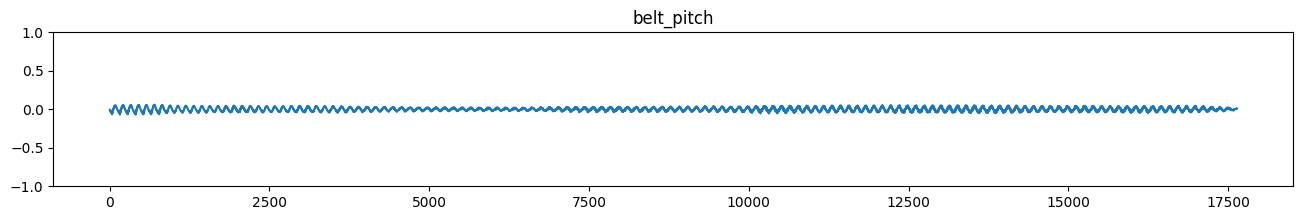

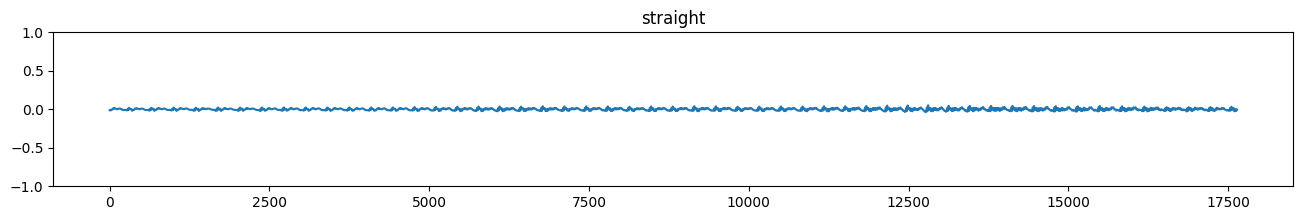

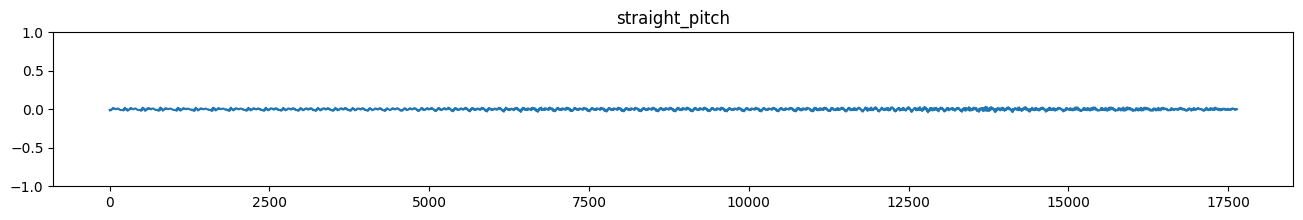

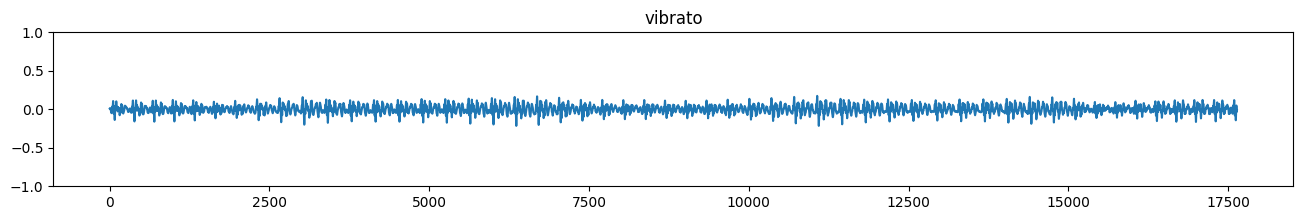

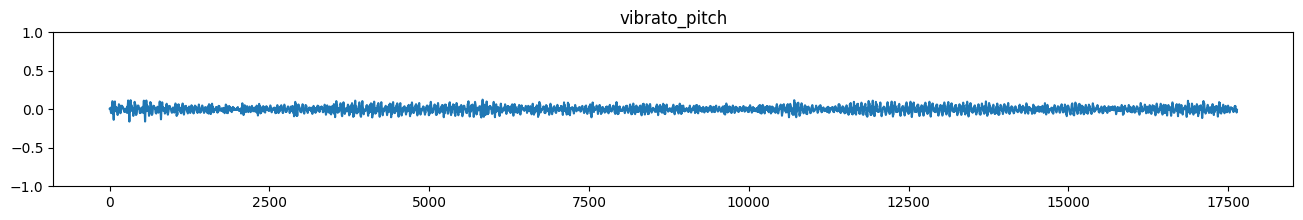

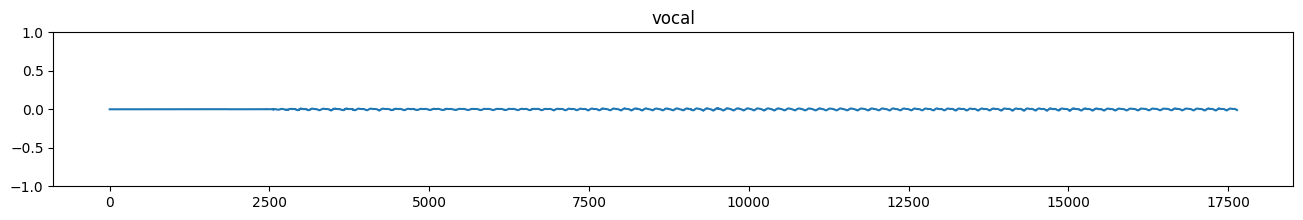

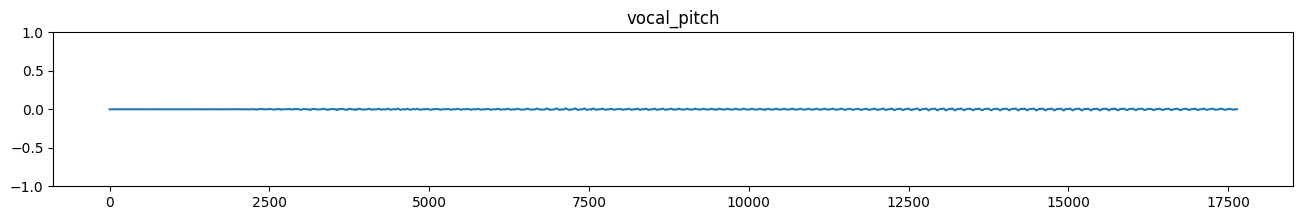

In [ ]:
show_aug(belt_audio, belt_pitch, 0, name = 'belt', aug = "pitch")
show_aug(straight_audio, straight_pitch, 0,name = 'straight', aug = "pitch")
show_aug(vibrato_audio, vibrato_pitch, 0, name = 'vibrato', aug = "pitch")
show_aug(vocal_fry_audio, vocal_fry_pitch, 0, name = 'vocal', aug = "pitch")

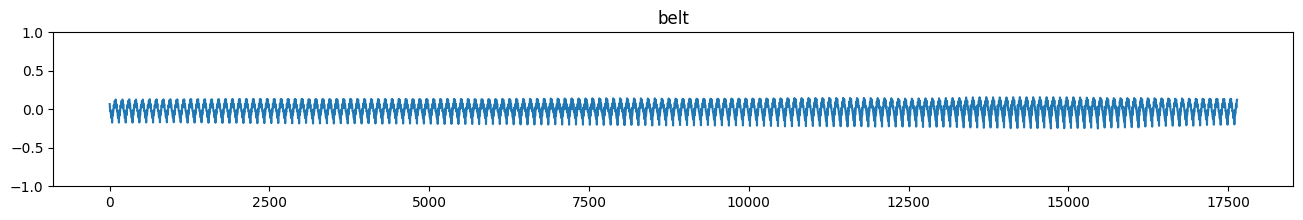

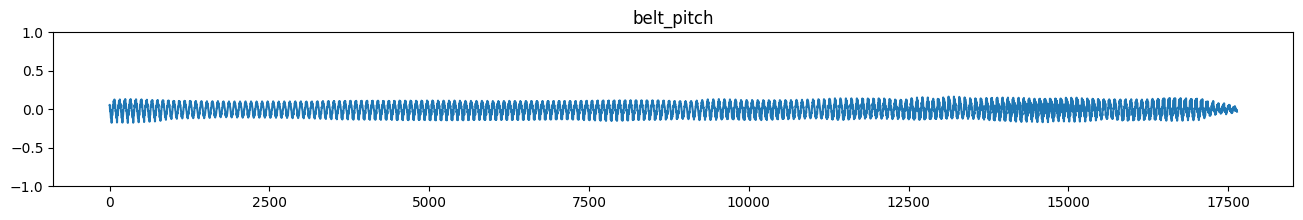

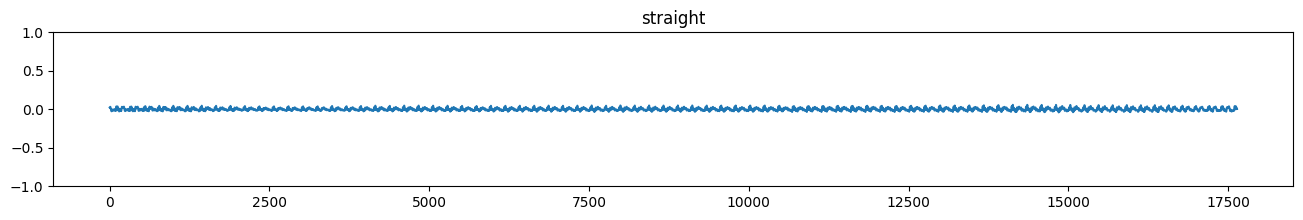

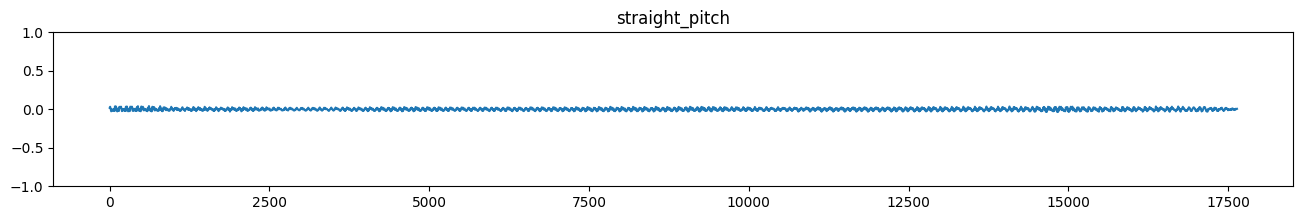

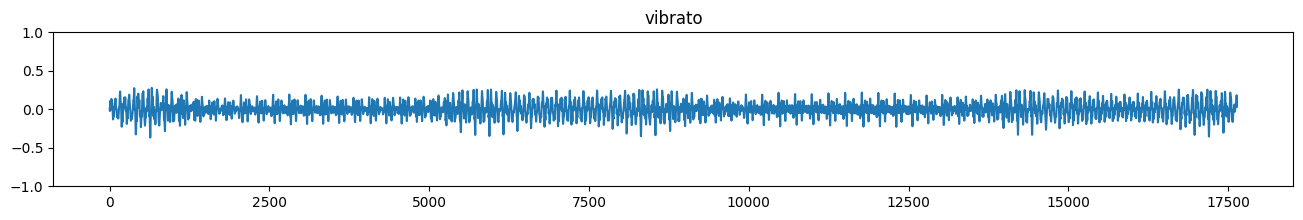

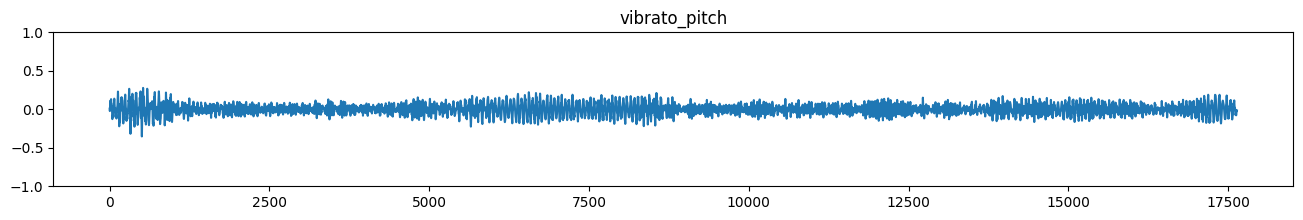

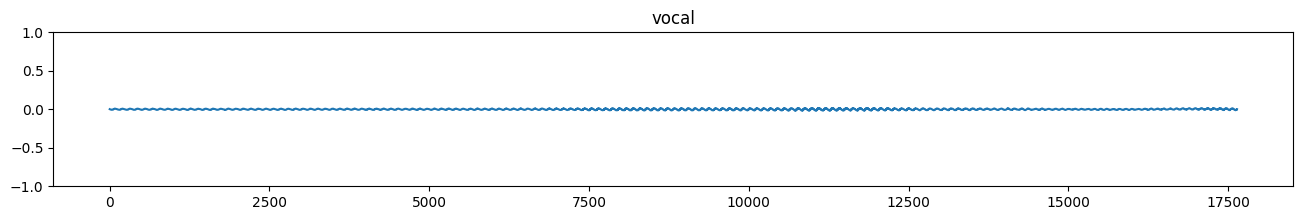

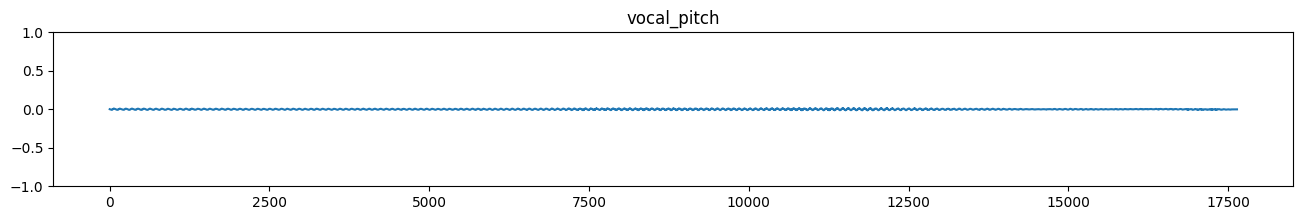

In [ ]:
show_aug(belt_audio, belt_pitch, 5, name = 'belt', aug = "pitch")
show_aug(straight_audio, straight_pitch, 5,name = 'straight', aug = "pitch")
show_aug(vibrato_audio, vibrato_pitch, 5, name = 'vibrato', aug = "pitch")
show_aug(vocal_fry_audio, vocal_fry_pitch, 5, name = 'vocal', aug = "pitch")

In [ ]:
belt_data = [belt_audio, belt_noise, belt_pitch]
straight_data = [straight_audio, straight_noise, straight_pitch]
vibrato_data = [vibrato_audio, vibrato_noise, vibrato_pitch]
vocal_fry_data = [vocal_fry_audio, vocal_fry_noise, vocal_fry_pitch]

# STFT

In [ ]:
def show_stft(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.stft(i[idx], n_fft=2048, win_length = 2048, hop_length=512)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

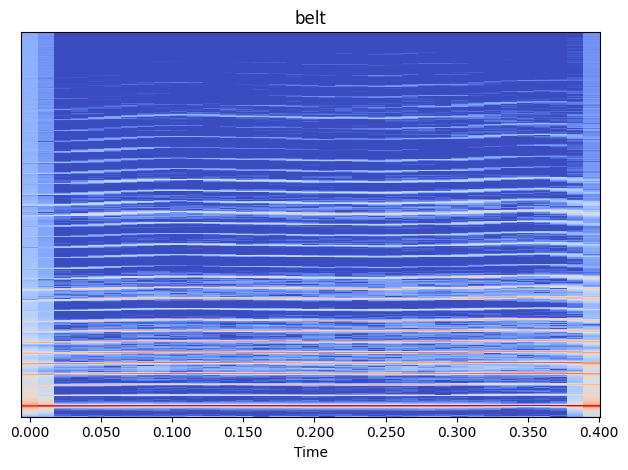

----------


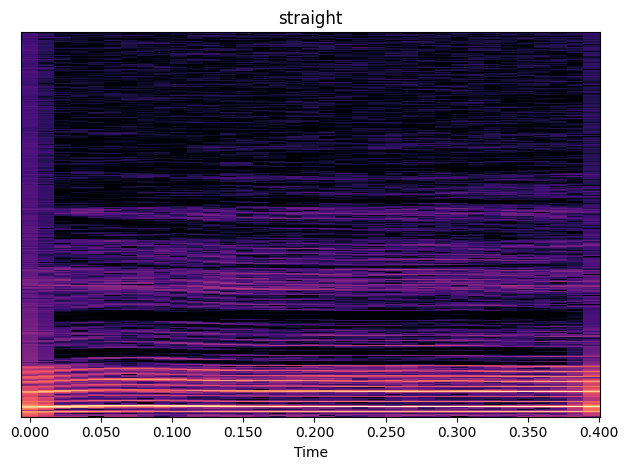

----------


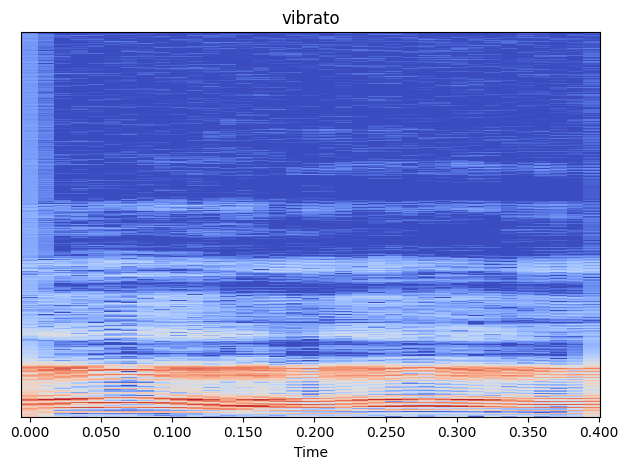

----------


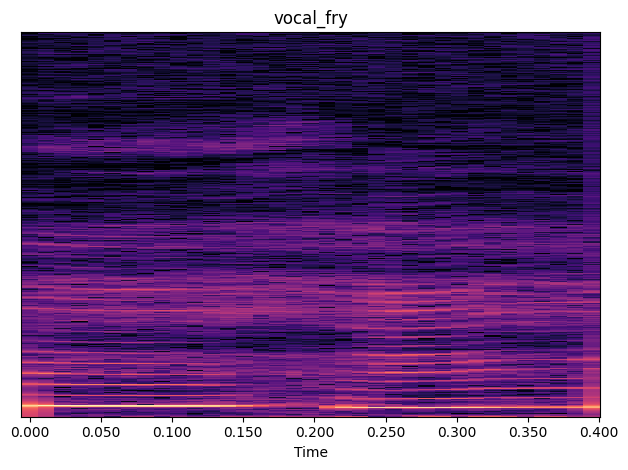

----------


In [ ]:
show_stft(technique_data, 10, ["belt","straight","vibrato",'vocal_fry'])

### 1) compare stft & standardized stft




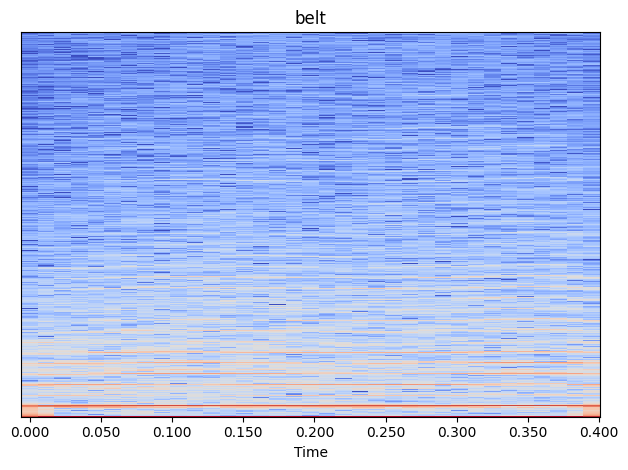

----------


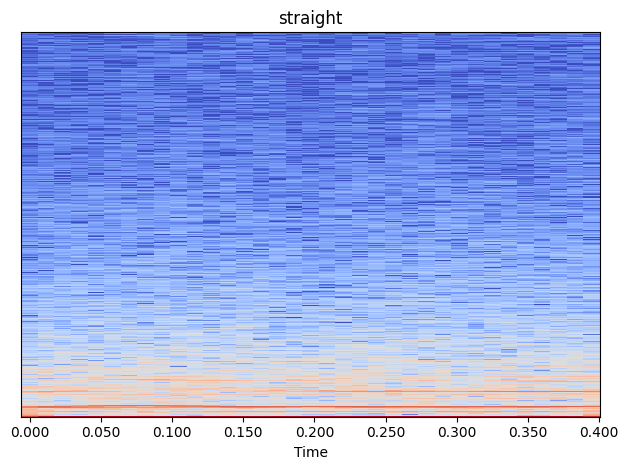

----------


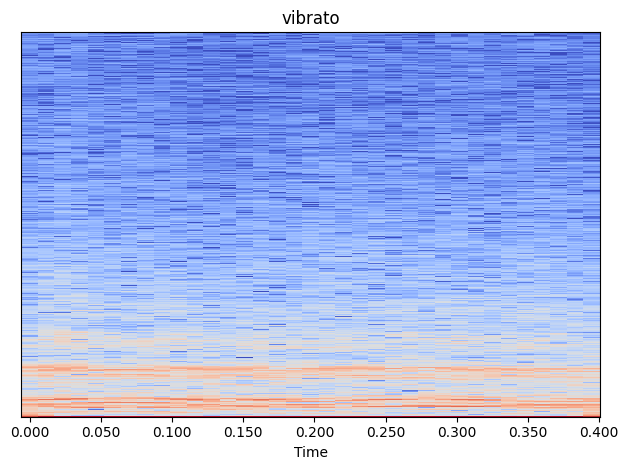

----------


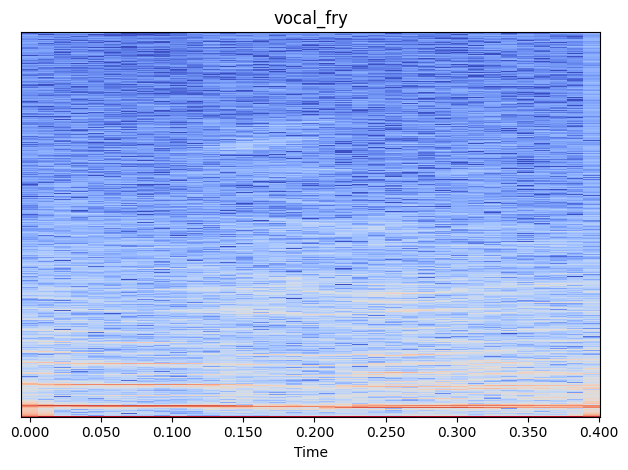

----------


In [ ]:
show_stft(std_data, 10, ["belt","straight","vibrato",'vocal_fry'])

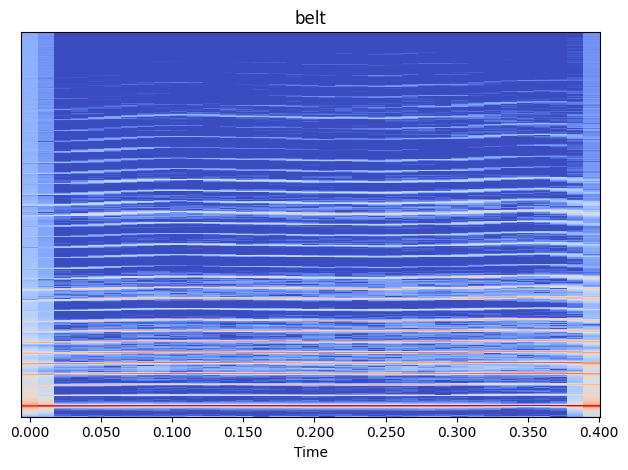

----------


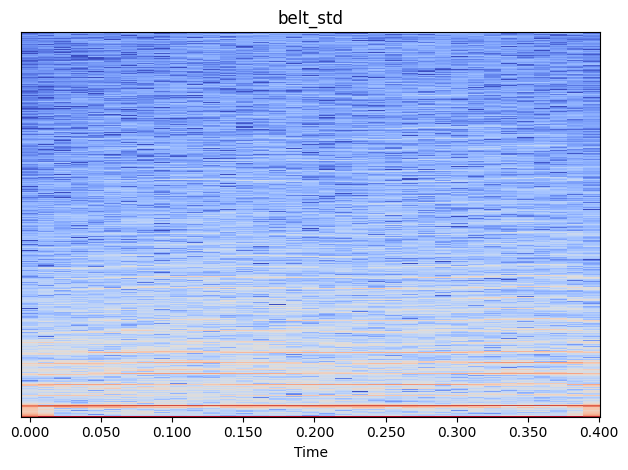

----------


In [ ]:
show_stft([belt_audio, belt_std], 10, ["belt", "belt_std"])

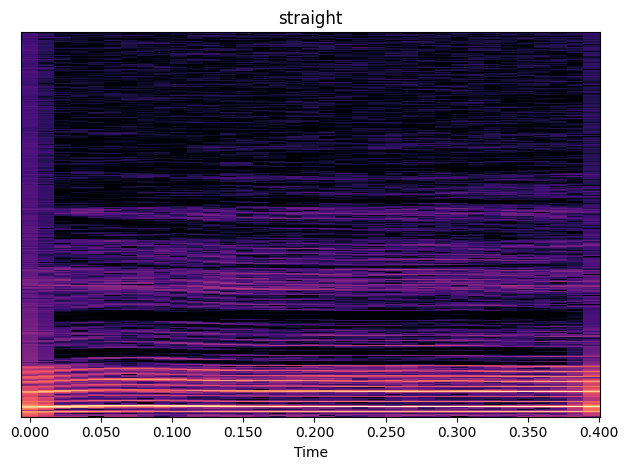

----------


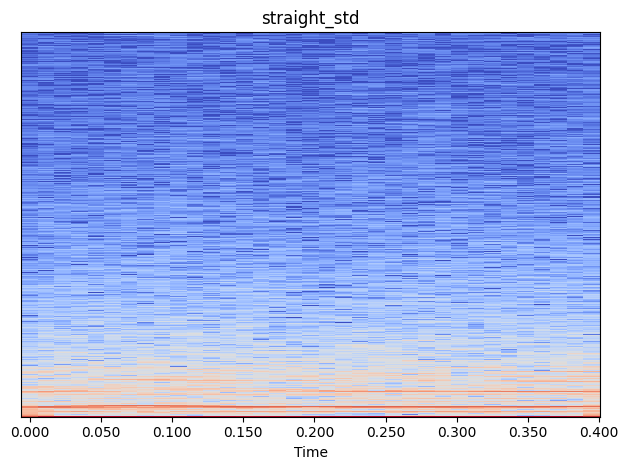

----------


In [ ]:
show_stft([straight_audio, straight_std], 10, ["straight", "straight_std"])

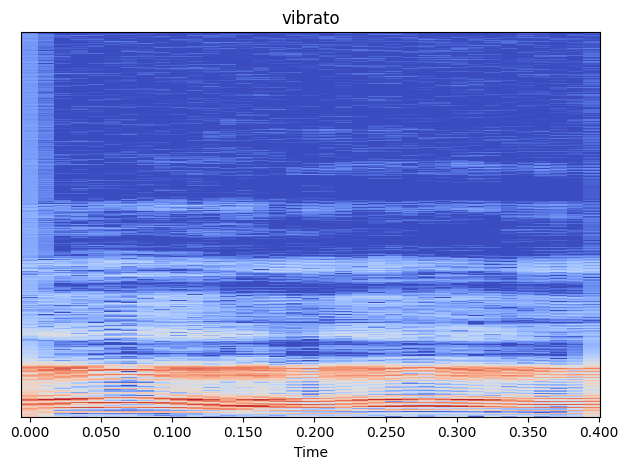

----------


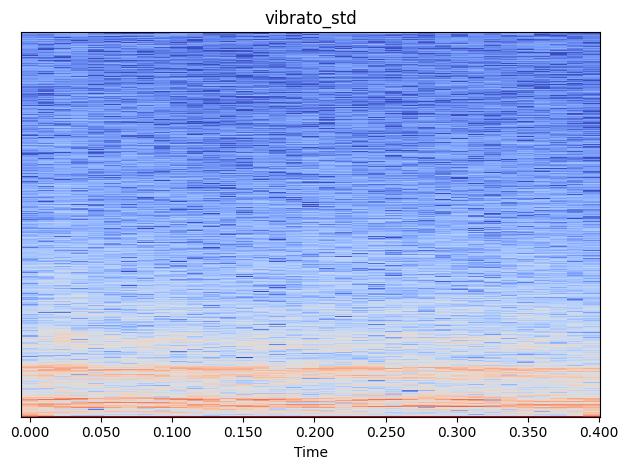

----------


In [ ]:
show_stft([vibrato_audio, vibrato_std], 10, ["vibrato", "vibrato_std"])

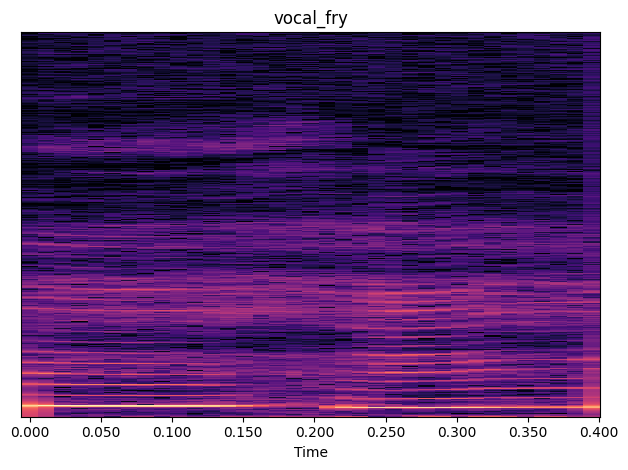

----------


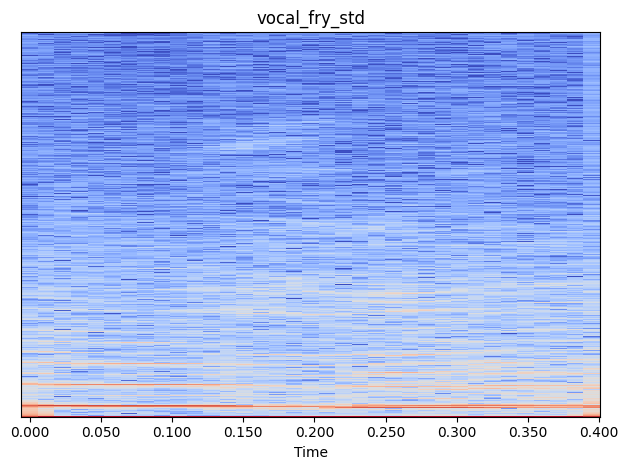

----------


In [ ]:
show_stft([vocal_fry_audio, vocal_fry_std], 10, ["vocal_fry", "vocal_fry_std"])

### 2) belt + augmented

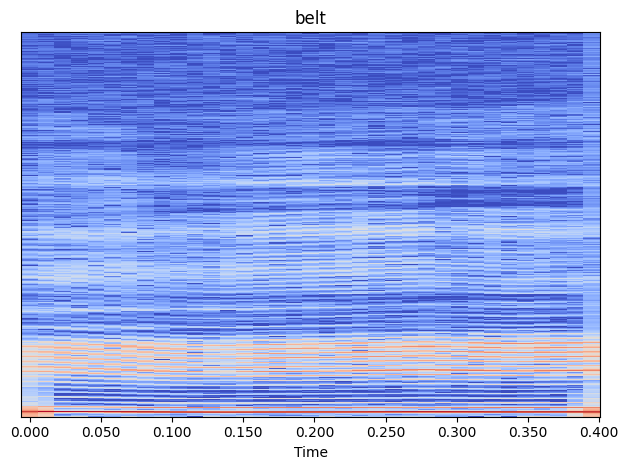

----------


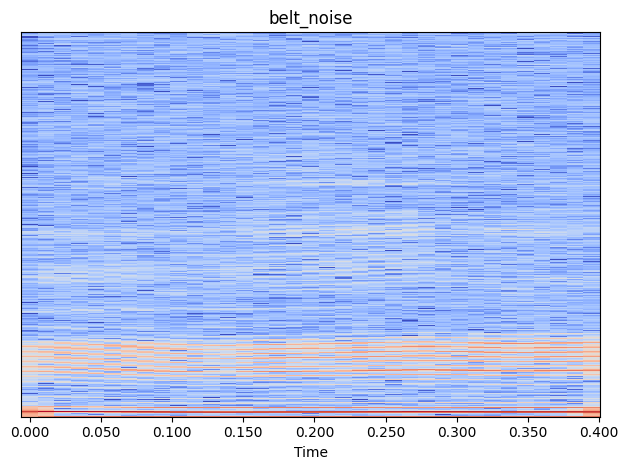

----------


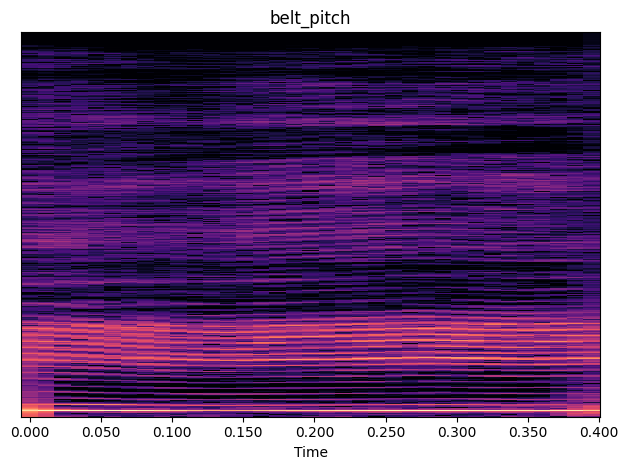

----------


In [ ]:
show_stft(belt_data,0, name=["belt", "belt_noise", "belt_pitch"])

### 3) straight + augmented

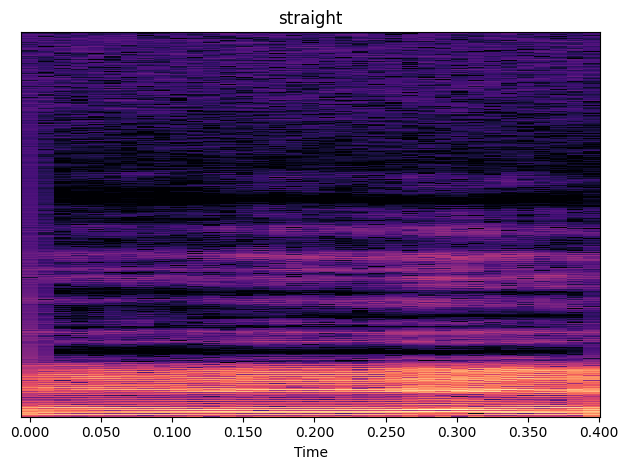

----------


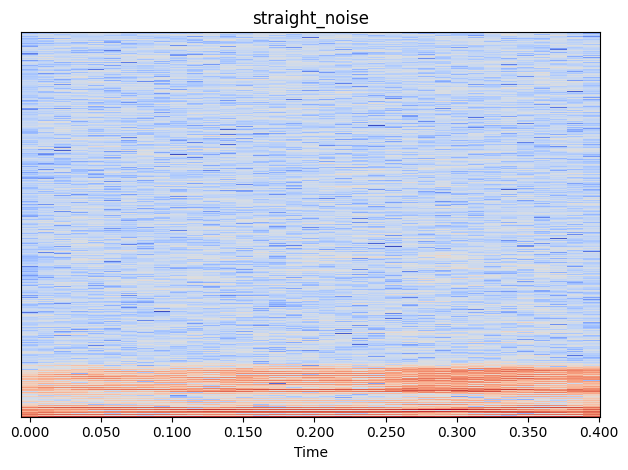

----------


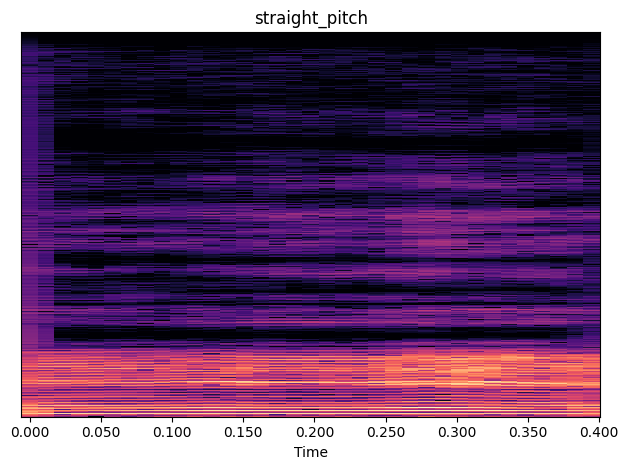

----------


In [ ]:
show_stft(straight_data,0, name=["straight", "straight_noise", "straight_pitch"])

### 4) vibrato + augmented

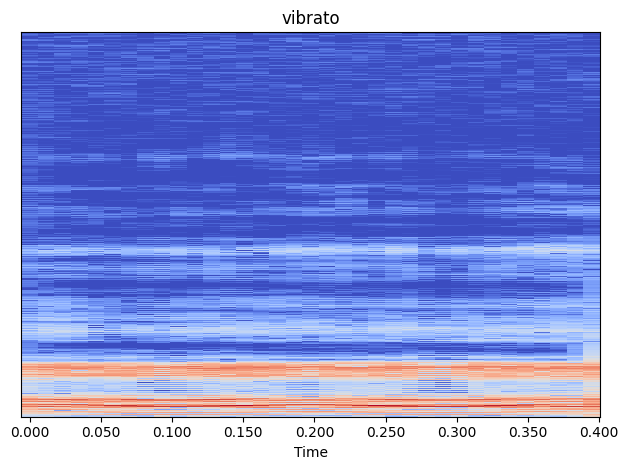

----------


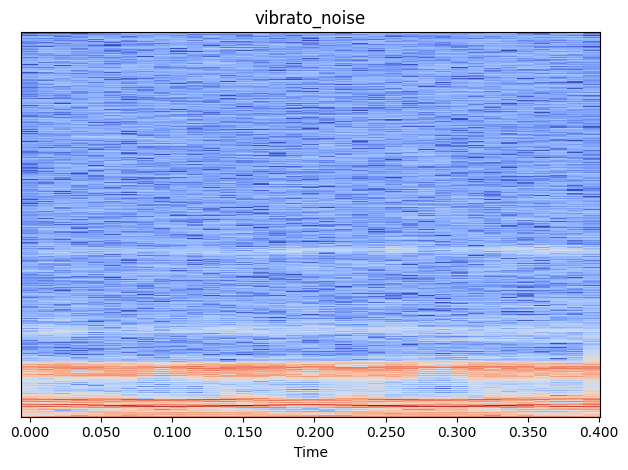

----------


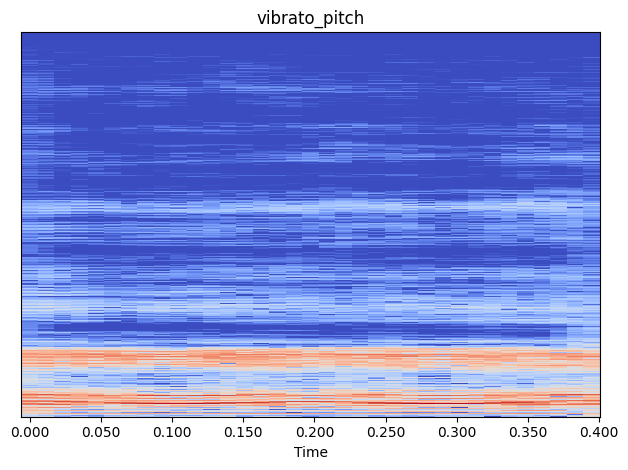

----------


In [ ]:
show_stft(vibrato_data,0, name=["vibrato", "vibrato_noise", "vibrato_pitch"])

### 5) vocal_fry + augmented

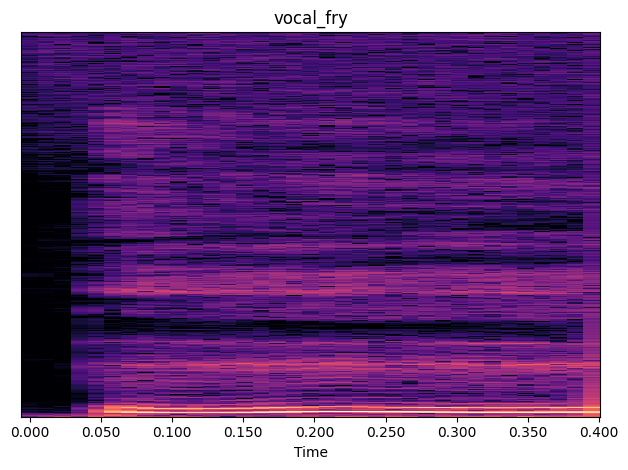

----------


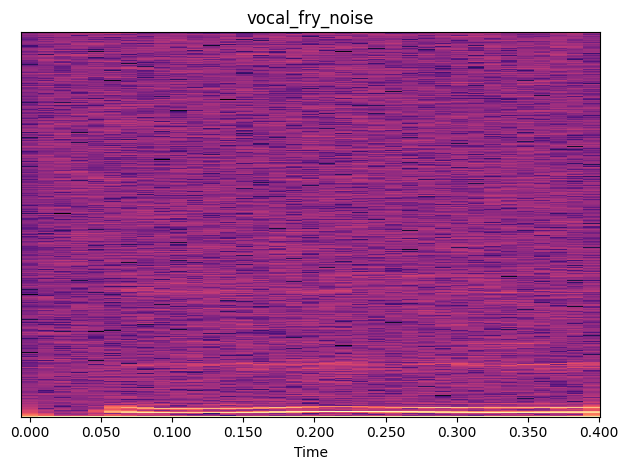

----------


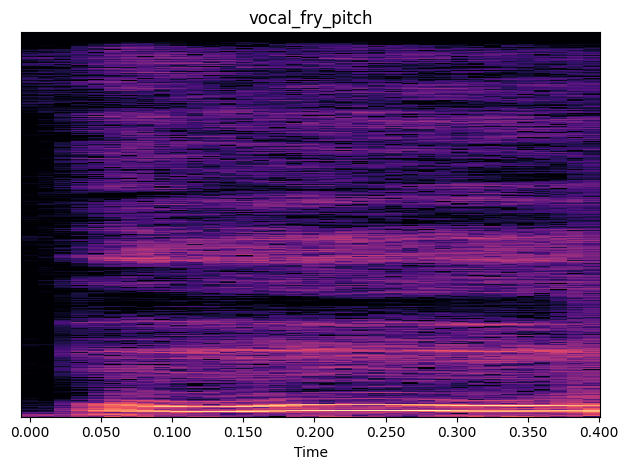

----------


In [ ]:
show_stft(vocal_fry_data,0, name=["vocal_fry", "vocal_fry_noise", "vocal_fry_pitch"])

# Mel

In [20]:
def show_mel_wrong_power_to_db(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.melspectrogram(y = i[idx], sr = 44100)
    amp = librosa.power_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

In [56]:
def show_mel_right_power_to_db(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.melspectrogram(y = i[idx], sr = 44100)
    amp = librosa.power_to_db(np.abs(ret)**2)
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

In [68]:
def show_mel(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.melspectrogram(y = i[idx], sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    print(amp)
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

### 0) normal data

[[24.101482  12.010964  -5.6005936 ... -5.6005936 -4.5839148 16.845345 ]
 [25.00869   12.18082   -5.6005936 ... -5.6005936 -5.6005936 18.694414 ]
 [25.014343  12.344545  -5.6005936 ... -5.6005936 -5.2695155 20.182262 ]
 ...
 [-5.6005936 -5.6005936 -5.6005936 ... -5.6005936 -5.6005936 -5.6005936]
 [-5.6005936 -5.6005936 -5.6005936 ... -5.6005936 -5.6005936 -5.6005936]
 [-5.6005936 -5.6005936 -5.6005936 ... -5.6005936 -5.6005936 -5.6005936]]


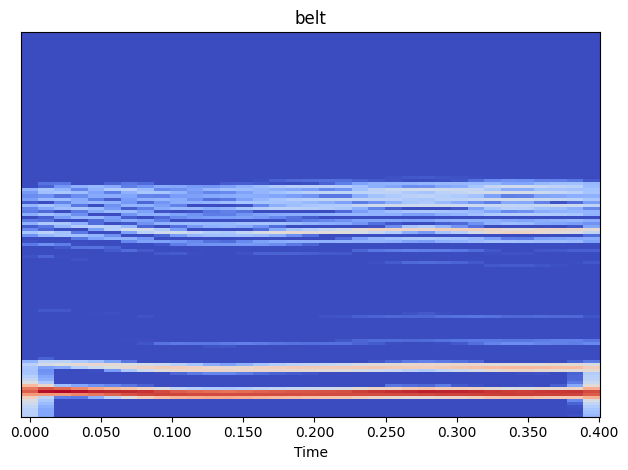

----------
[[ -9.633459  -16.07724   -19.652384  ... -19.419224  -19.155485
    8.451985 ]
 [  2.6984832  -9.212724  -10.476848  ... -16.840284  -24.877985
   11.0797   ]
 [ 20.275698   24.20763    27.014315  ...  23.555676   23.771906
   25.893196 ]
 ...
 [-27.84439   -27.84439   -27.84439   ... -27.84439   -27.84439
  -27.84439  ]
 [-27.84439   -27.84439   -27.84439   ... -27.84439   -27.84439
  -27.84439  ]
 [-27.84439   -27.84439   -27.84439   ... -27.84439   -27.84439
  -27.84439  ]]


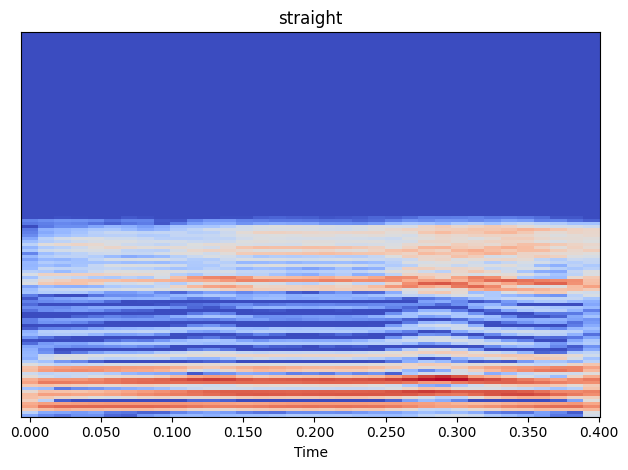

----------
[[ 1.9429855  1.9429855  1.9429855 ...  1.9429855  1.9429855 13.153878 ]
 [ 1.9429855  1.9429855  1.9429855 ...  1.9429855  1.9429855 17.792835 ]
 [ 1.9429855  1.9429855  6.99067   ...  3.6663482  7.419503  22.976263 ]
 ...
 [ 1.9429855  1.9429855  1.9429855 ...  1.9429855  1.9429855  1.9429855]
 [ 1.9429855  1.9429855  1.9429855 ...  1.9429855  1.9429855  1.9429855]
 [ 1.9429855  1.9429855  1.9429855 ...  1.9429855  1.9429855  1.9429855]]


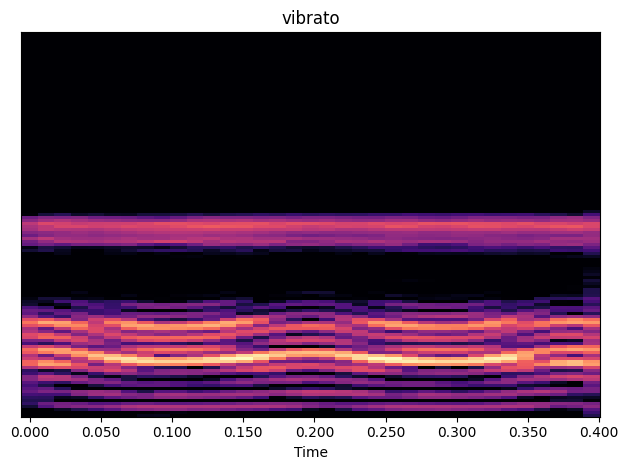

----------
[[-29.705067 -29.705067 -26.773262 ...  -8.528172 -17.211731 -10.024272]
 [-29.705067 -29.705067 -29.705067 ... -23.005241 -17.125834  -4.585795]
 [-29.705067 -29.705067 -29.705067 ... -29.705067 -29.361076  -8.670433]
 ...
 [-29.705067 -29.705067 -29.705067 ... -29.705067 -29.705067 -29.705067]
 [-29.705067 -29.705067 -29.705067 ... -29.705067 -29.705067 -29.705067]
 [-29.705067 -29.705067 -29.705067 ... -29.705067 -29.705067 -29.705067]]


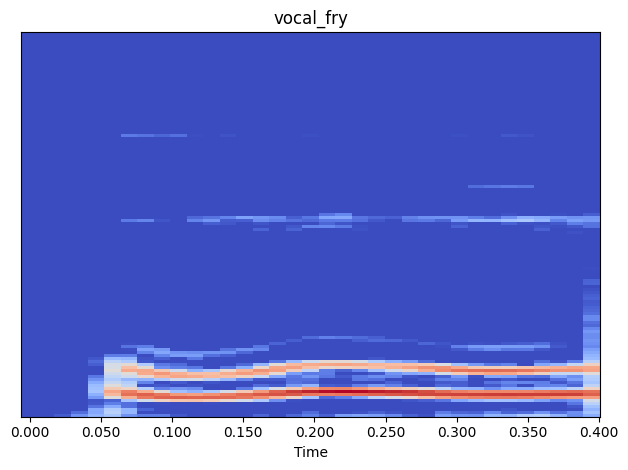

----------


In [70]:
show_mel(std_data, 0, ["belt","straight","vibrato",'vocal_fry'])

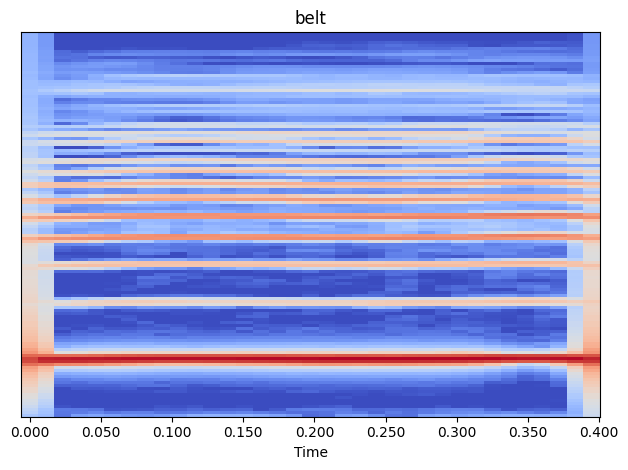

----------


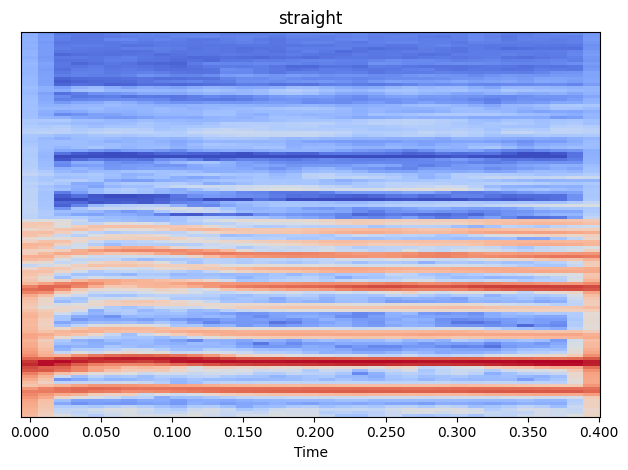

----------


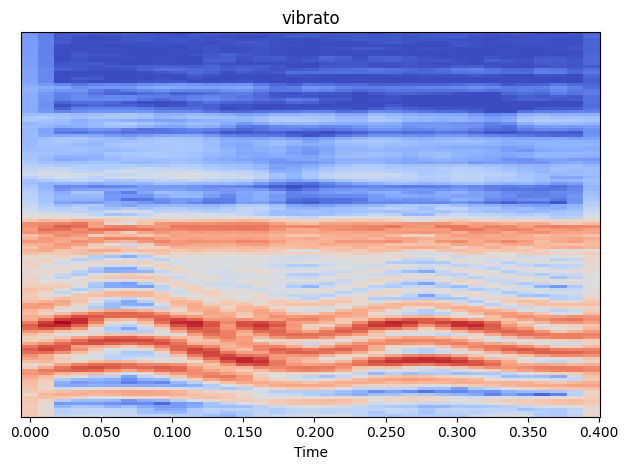

----------


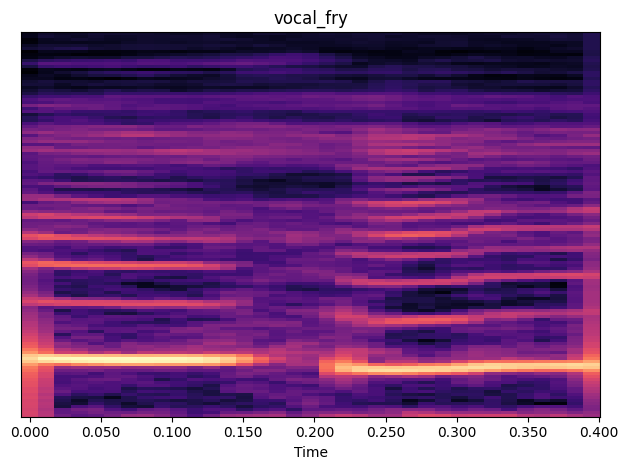

----------


In [37]:
show_mel_wrong_power_to_db(technique_data, 10, ["belt","straight","vibrato",'vocal_fry'])

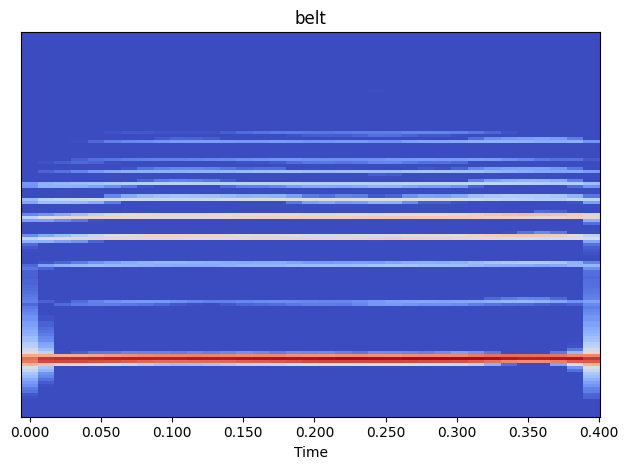

----------


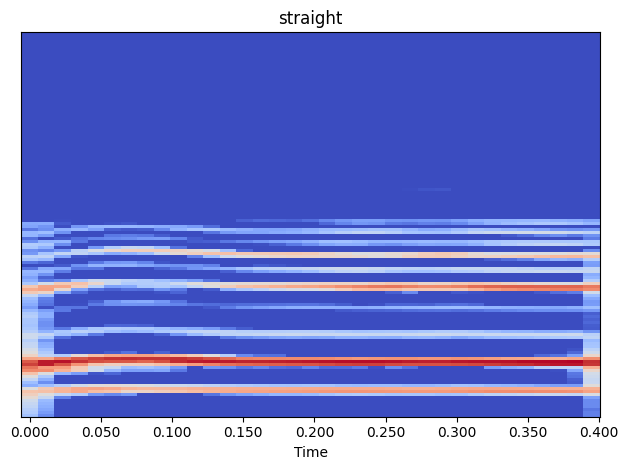

----------


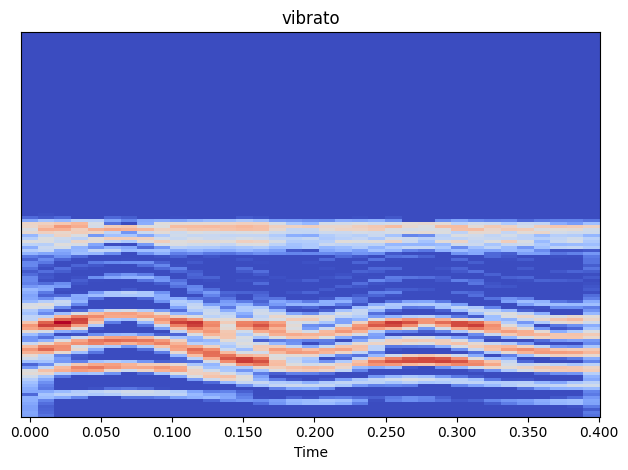

----------


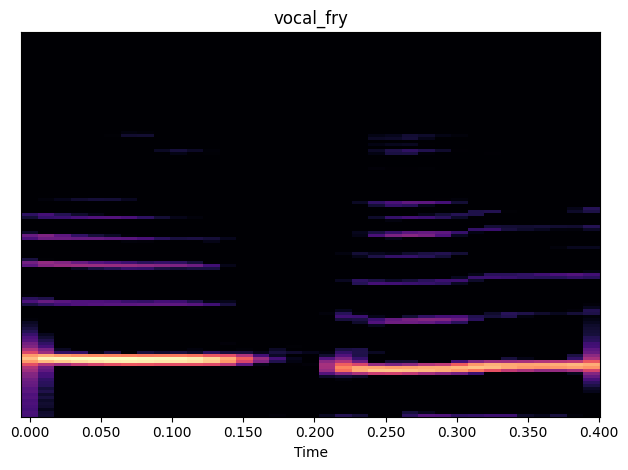

----------


In [48]:
show_mel_right_power_to_db(technique_data, 10, ["belt","straight","vibrato",'vocal_fry'])

In [50]:
import copy
import random
def freq_mask(spec, num_masks=1):
    test = copy.deepcopy(spec)
    num_mel_channels = test.shape[0]
    F = int(0.3*num_mel_channels)
    for i in range(0, num_masks):        
        freq = random.randrange(3, F)
        print(freq)
        zero = random.randrange(0, num_mel_channels - freq)
        # avoids randrange error if values are equal and range is empty
        if (zero == zero + freq): return test
        mask_end = random.randrange(zero+2, zero + freq) 
        print(zero, mask_end)
        test[zero:mask_end] = test.mean()
    return test

def time_mask(spec, num_masks=1):
    test = copy.deepcopy(spec)
    length = test.shape[1]
    time = int(0.3*length)
    for i in range(0, num_masks):
        t = random.randrange(3, time)
        zero = random.randrange(0, length - t)
        if (zero == zero + t): return 0
        mask_end = random.randrange(zero+2, zero + t)
        print(zero, mask_end)
        test[:,zero:mask_end] = test.mean()
    return test

In [ ]:
ret = librosa.feature.melspectrogram(y = np.array(belt_audio[0]), sr = 44100)
amp = librosa.amplitude_to_db(np.abs(ret))
tmp = freq_mask(amp)
tmp2 = time_mask(amp)

33
31 44
9 11


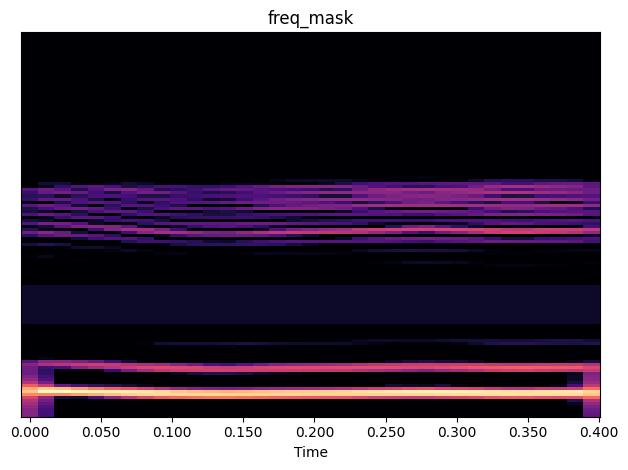

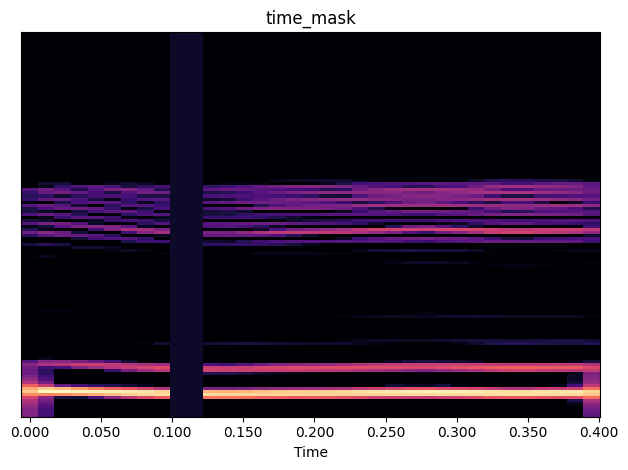

In [ ]:
show_spec(data = tmp, name = "freq_mask")
show_spec(data = tmp2, name = "time_mask")

### 1) compare mel & standardized mel


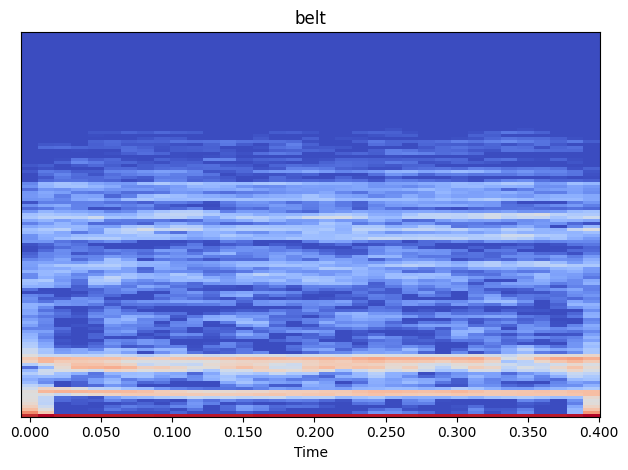

----------


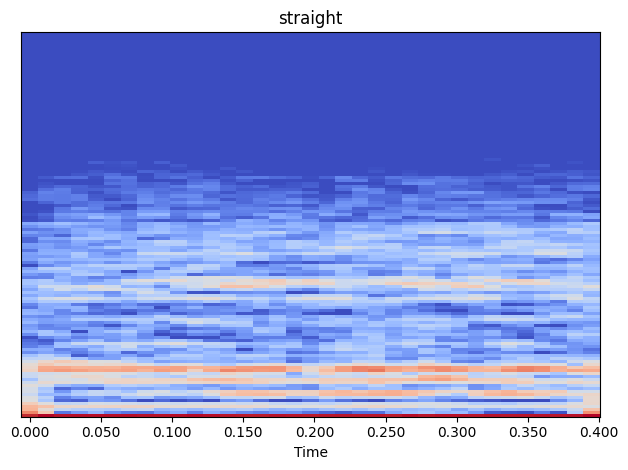

----------


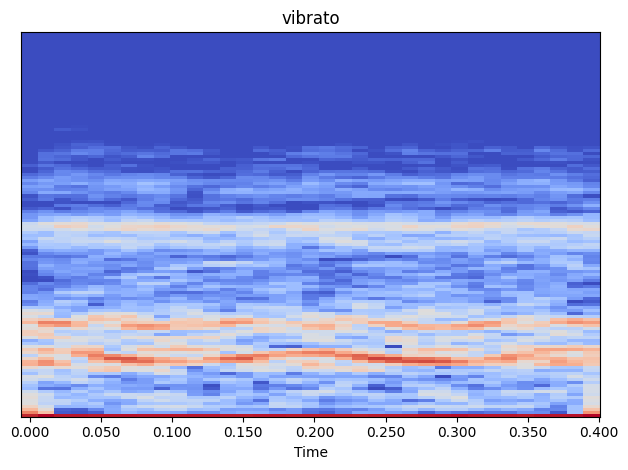

----------


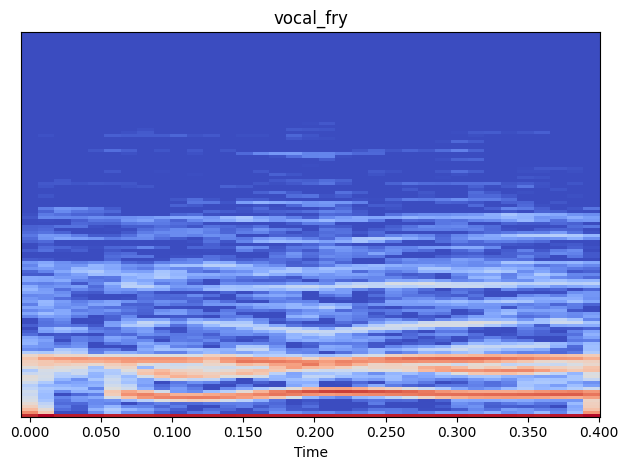

----------


In [ ]:
show_mel(std_data, 0, ["belt","straight","vibrato",'vocal_fry'])

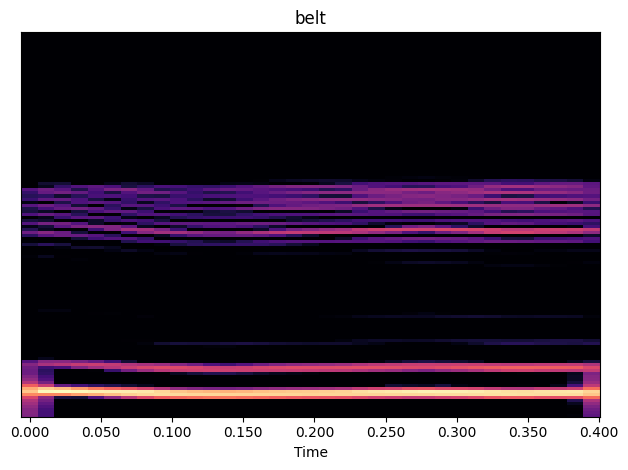

----------


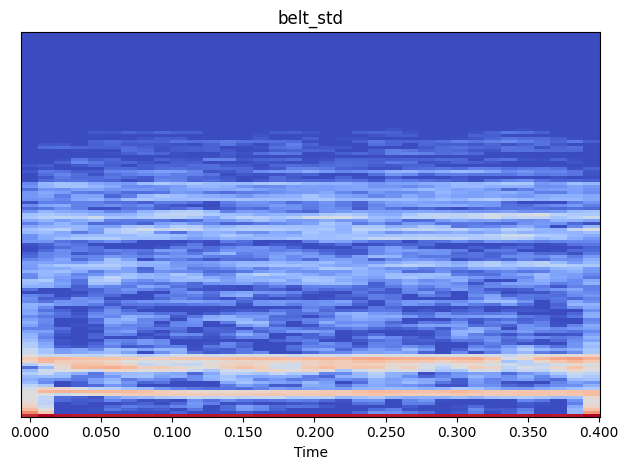

----------


In [ ]:
show_mel([belt_audio, belt_std], 0, ["belt", "belt_std"])

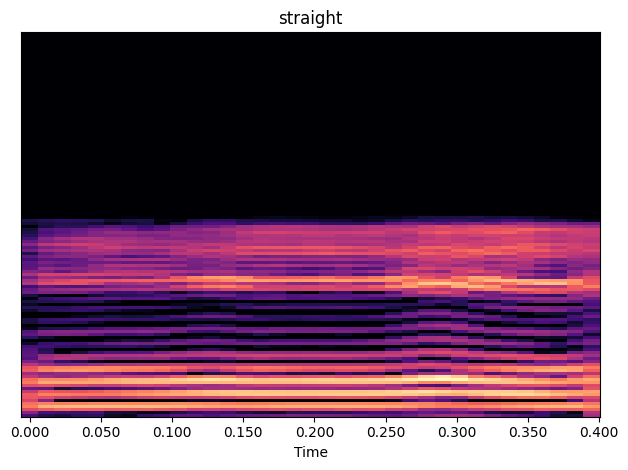

----------


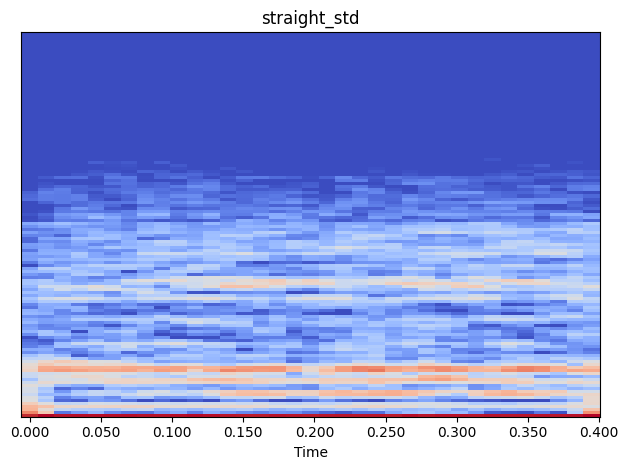

----------


In [ ]:
show_mel([straight_audio, straight_std], 0, ["straight", "straight_std"])

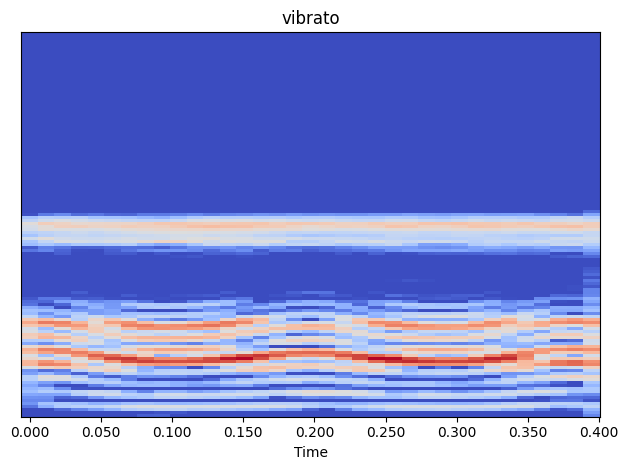

----------


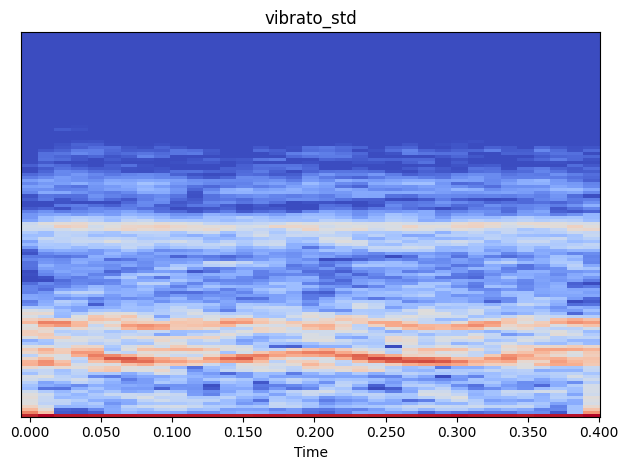

----------


In [ ]:
show_mel([vibrato_audio, vibrato_std], 0, ["vibrato", "vibrato_std"])

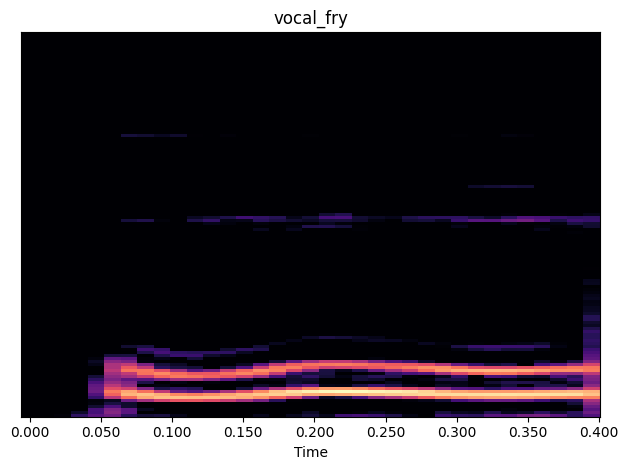

----------


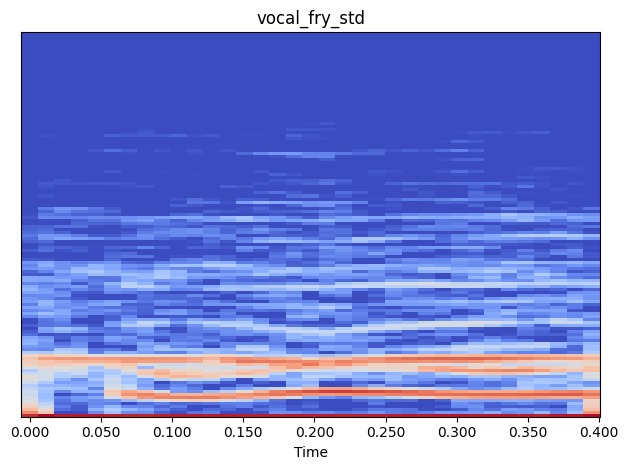

----------


In [ ]:
show_mel([vocal_fry_audio, vocal_fry_std], 0, ["vocal_fry", "vocal_fry_std"])

### 2) belt + augmented


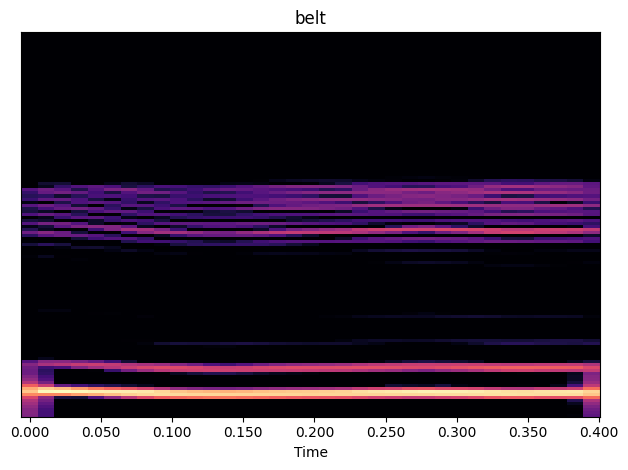

----------


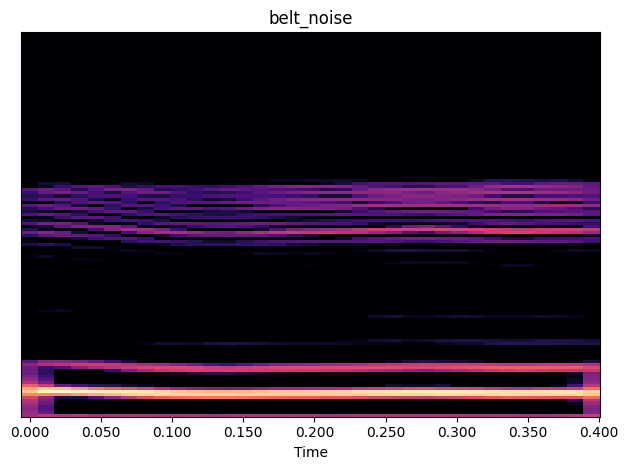

----------


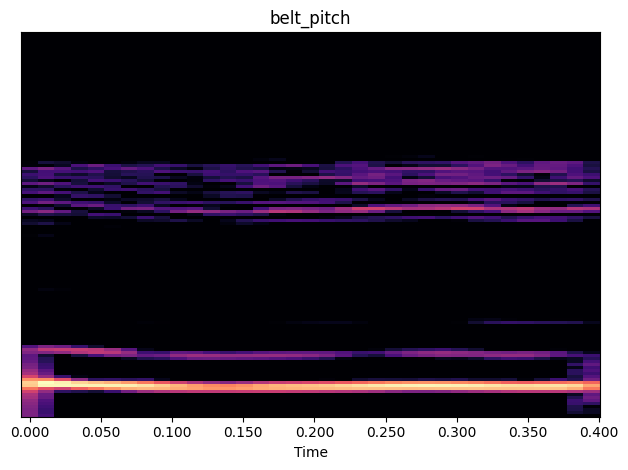

----------


In [ ]:
show_mel(belt_data,0, name=["belt", "belt_noise", "belt_pitch"])

### 3) straight + augmented


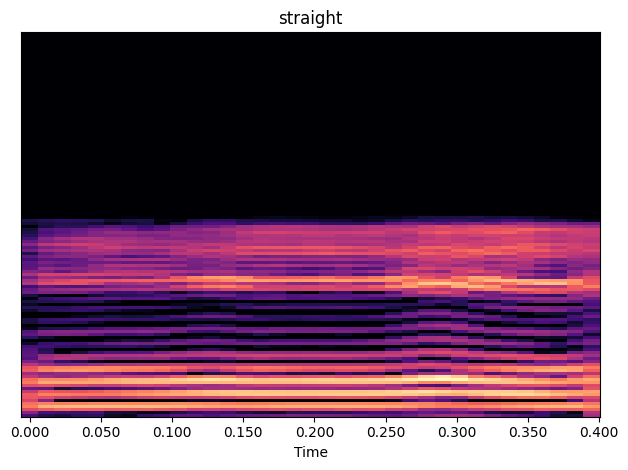

----------


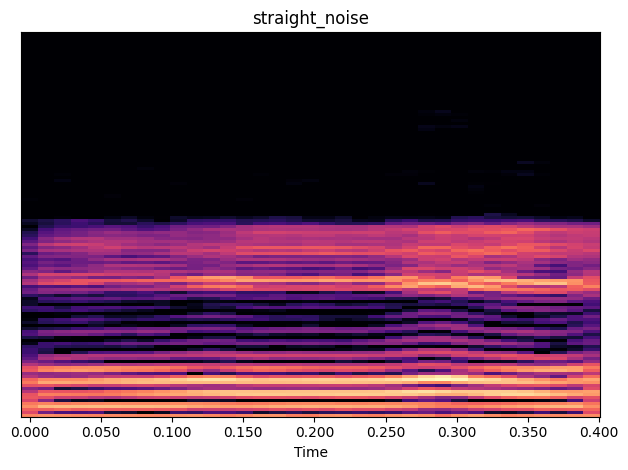

----------


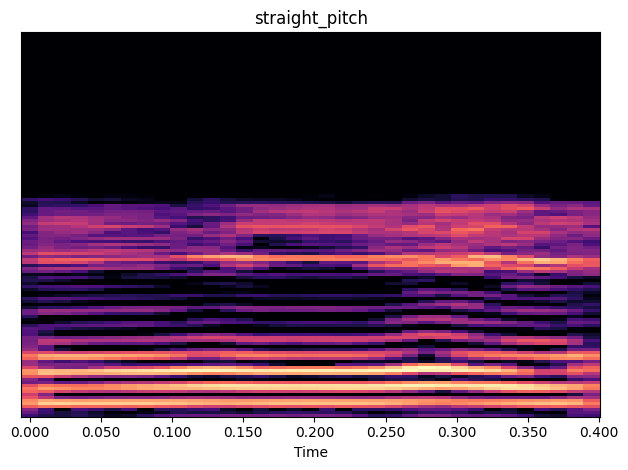

----------


In [ ]:
show_mel(straight_data,0, name=["straight", "straight_noise", "straight_pitch"])

### 4) vibrato + augmented


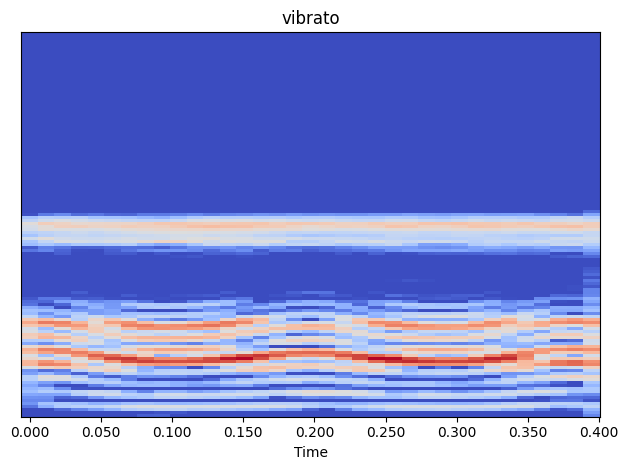

----------


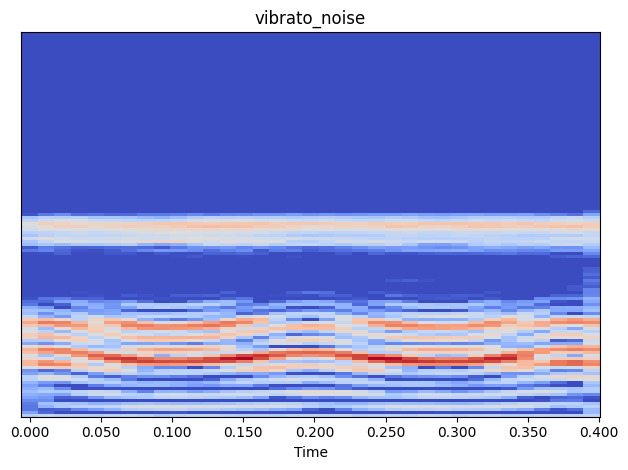

----------


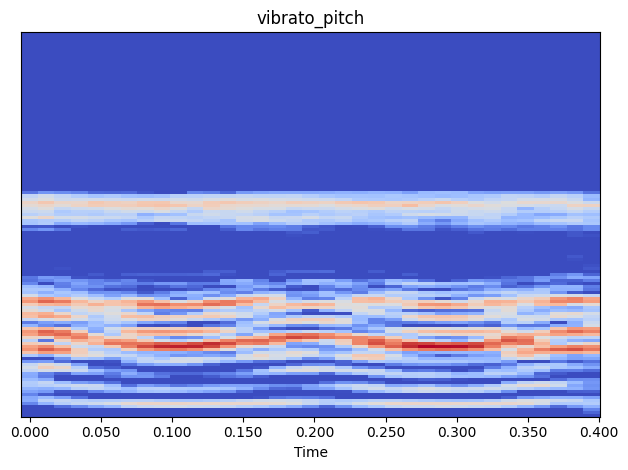

----------


In [ ]:
show_mel(vibrato_data,0, name=["vibrato", "vibrato_noise", "vibrato_pitch"])

### 5) vocal_fry + augmented


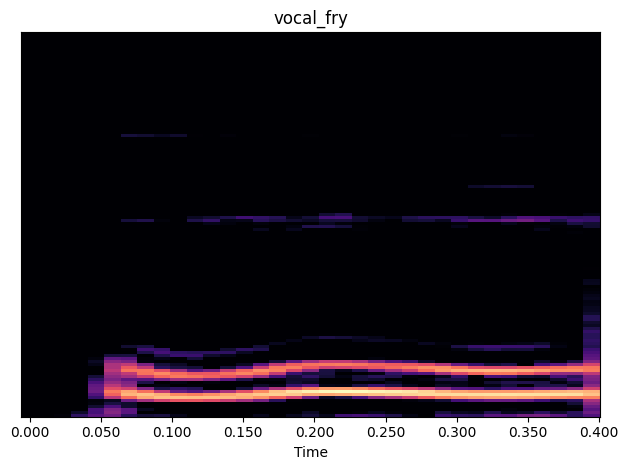

----------


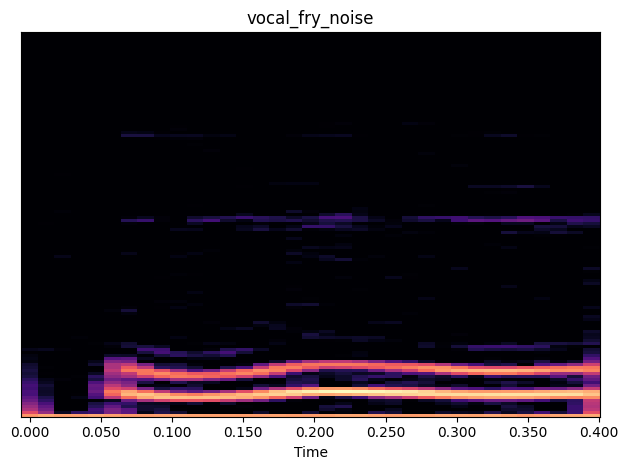

----------


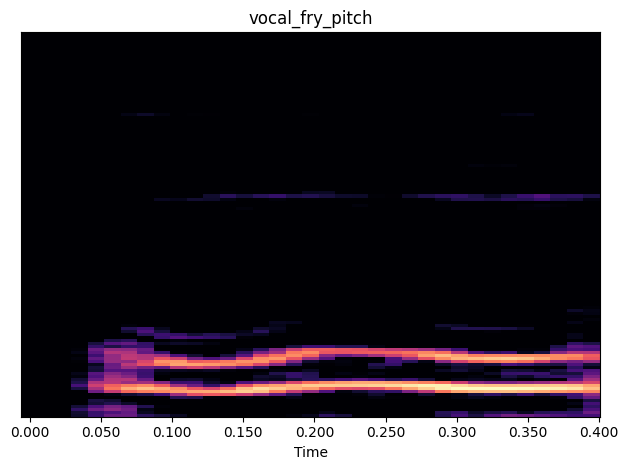

----------


In [ ]:
show_mel(vocal_fry_data,0, name=["vocal_fry", "vocal_fry_noise", "vocal_fry_pitch"])

### 6) magphase 유무
+ mel spectrogram이 더욱 선명해진다!

In [ ]:
def show_magphase_mel(data, idx,name):
  for name_idx,i in enumerate(data):
    sgram_mag, _ = librosa.magphase(i[idx])
    ret = librosa.feature.melspectrogram(y = sgram_mag, sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

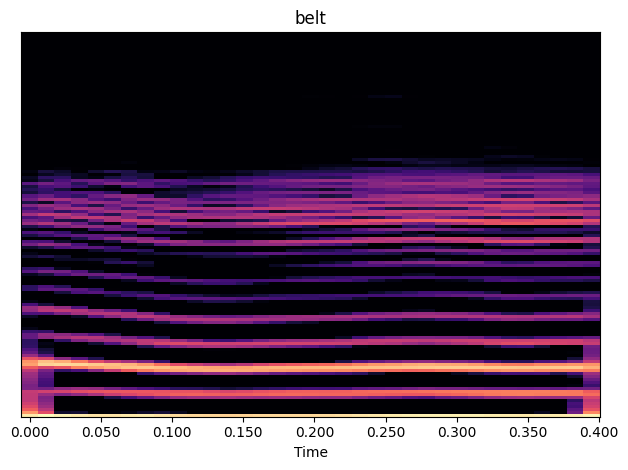

----------


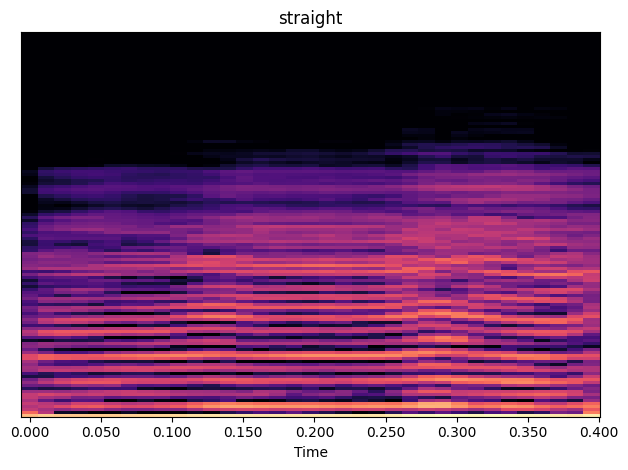

----------


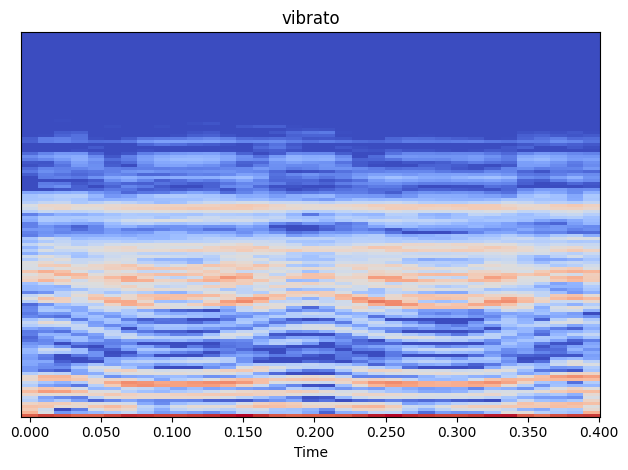

----------


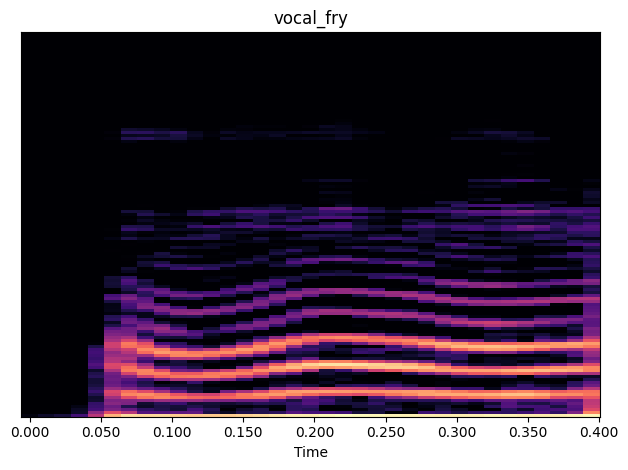

----------


In [ ]:
# no standardized + magphased
show_magphase_mel(technique_data, 0, ["belt","straight","vibrato",'vocal_fry'])

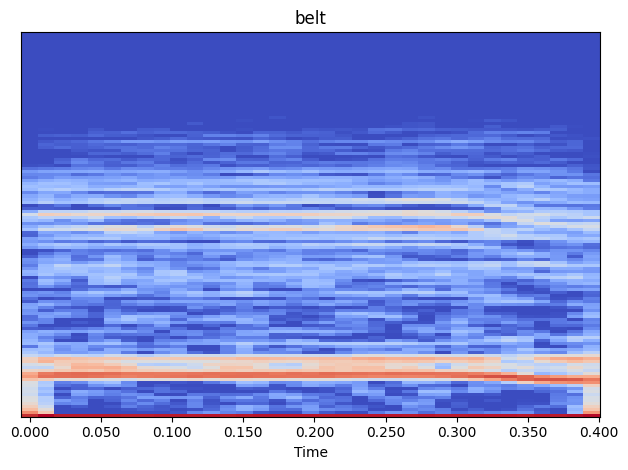

----------


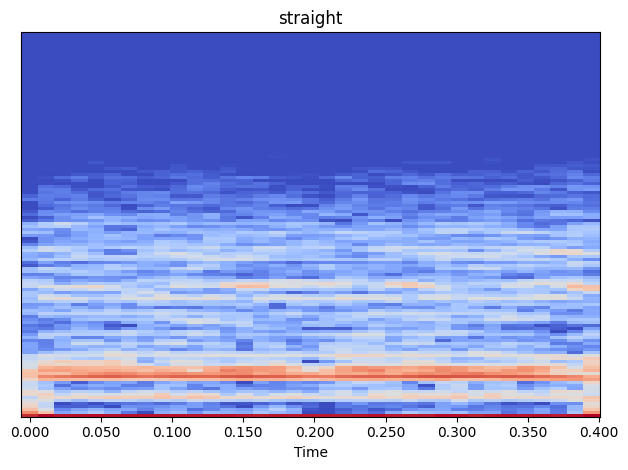

----------


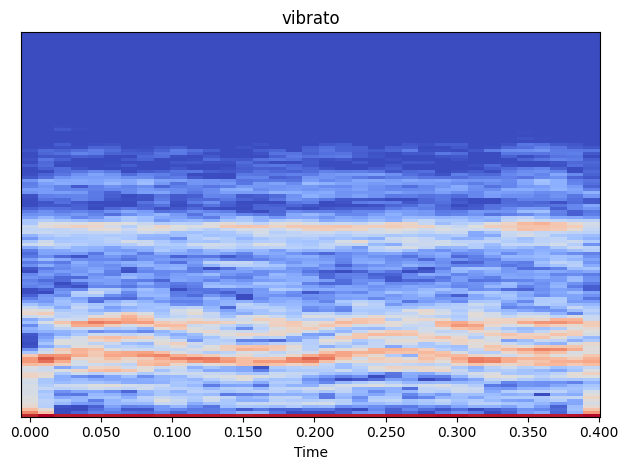

----------


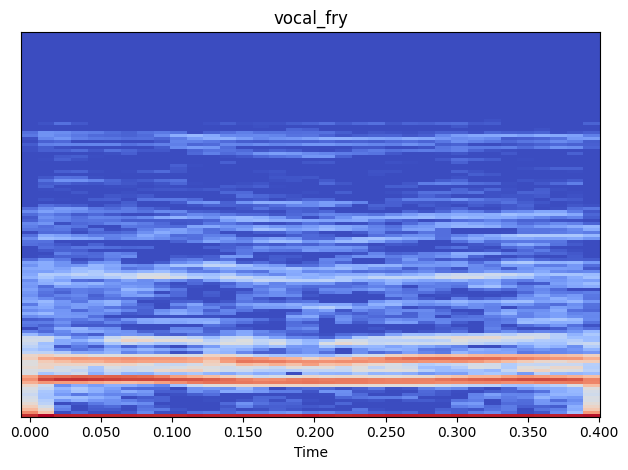

----------


In [ ]:
# standardized + magphased
show_magphase_mel(std_data, 14, ["belt","straight","vibrato",'vocal_fry'])

In [ ]:
def cmp_magphase(data, idx,name):
  print("magphrase X")
  ret1 = librosa.feature.melspectrogram(y = data[idx], sr = 44100)
  amp1 = librosa.amplitude_to_db(np.abs(ret1))
  show_spec(data = amp1, name = name)
 
  print("magphrase O")
  sgram_mag, _ = librosa.magphase(data[idx])
  ret2 = librosa.feature.melspectrogram(y = sgram_mag, sr = 44100)
  amp2 = librosa.amplitude_to_db(np.abs(ret2))
  show_spec(data = amp2, name = name + "_magphrase")

magphrase X


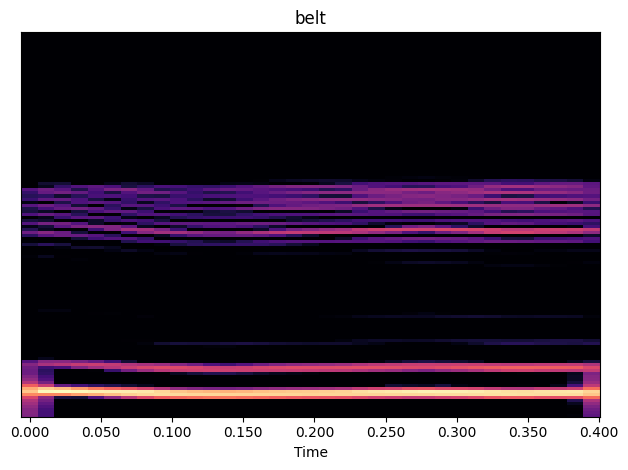

magphrase O


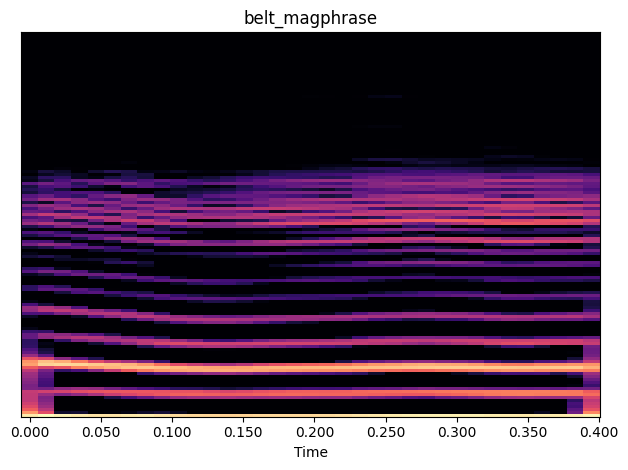

In [ ]:
cmp_magphase(belt_audio, 0, "belt")

magphrase X


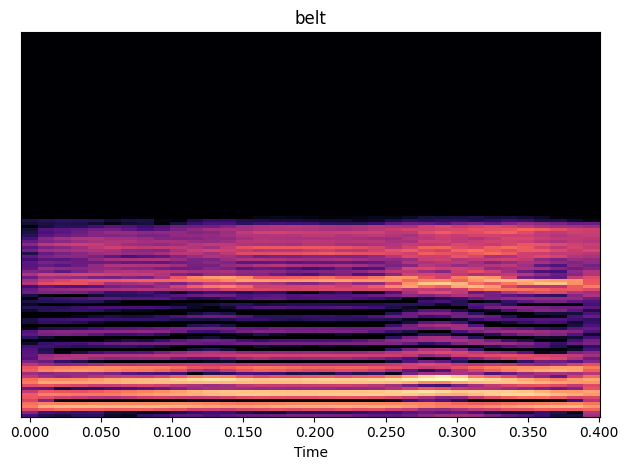

magphrase O


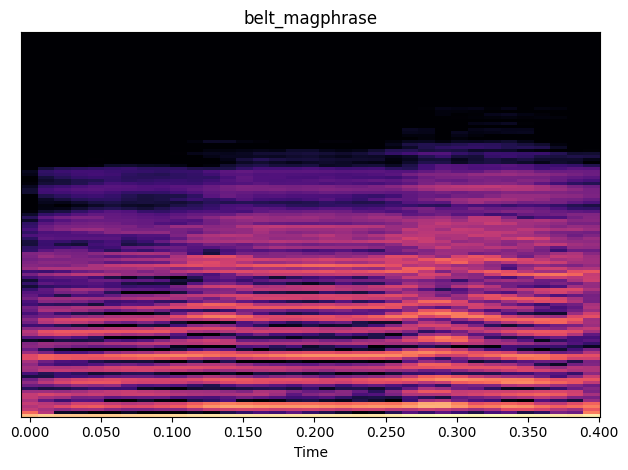

In [ ]:
cmp_magphase(straight_audio, 0, "belt")

magphrase X


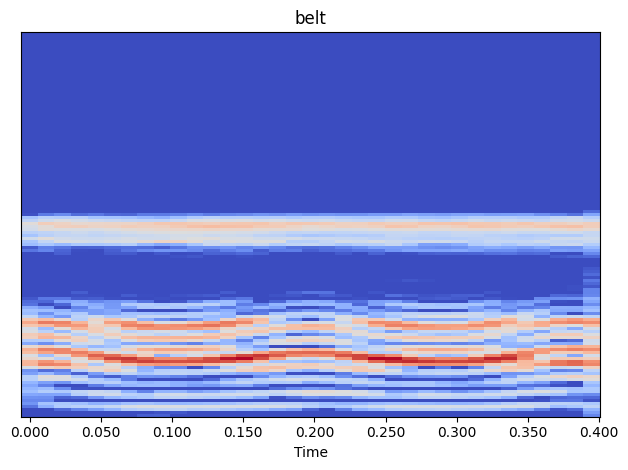

magphrase O


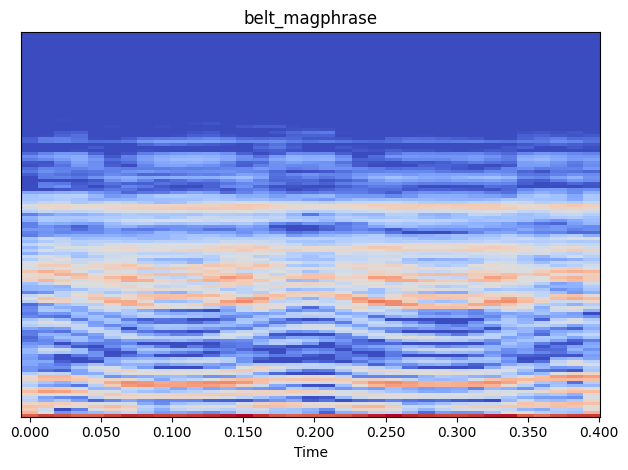

In [ ]:
cmp_magphase(vibrato_audio, 0, "belt")

magphrase X


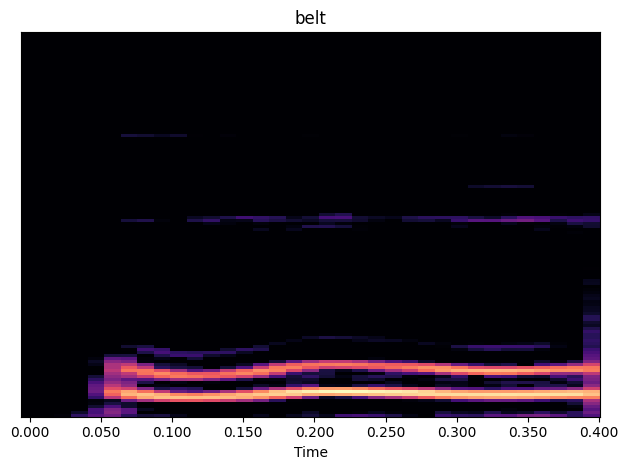

magphrase O


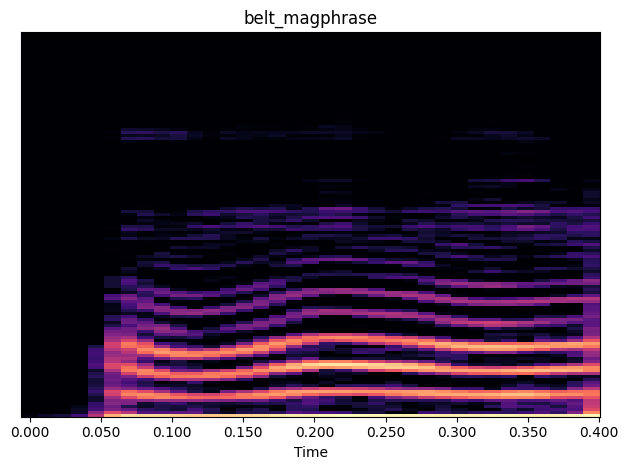

In [ ]:
cmp_magphase(vocal_fry_audio, 0, "belt")

### 7) amplitude_to_db 유무
+ ampliture_to_db을 사용하지 않을 시 너무 어둡다..!

In [ ]:
def show_no_db_mel(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.melspectrogram(y = i[idx], sr = 44100)
    show_spec(data = ret, name = name[name_idx])
    print("-"*10)

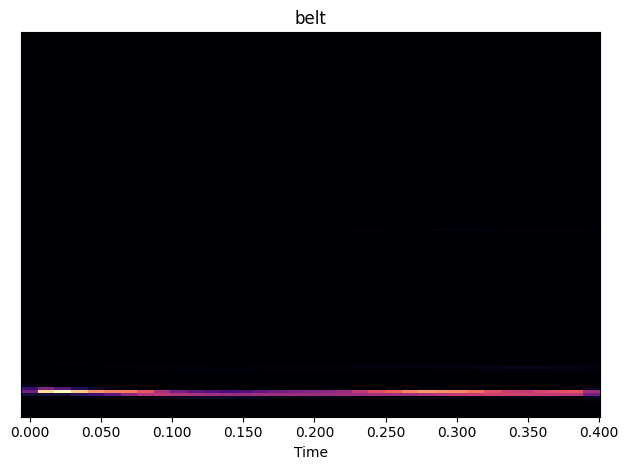

----------


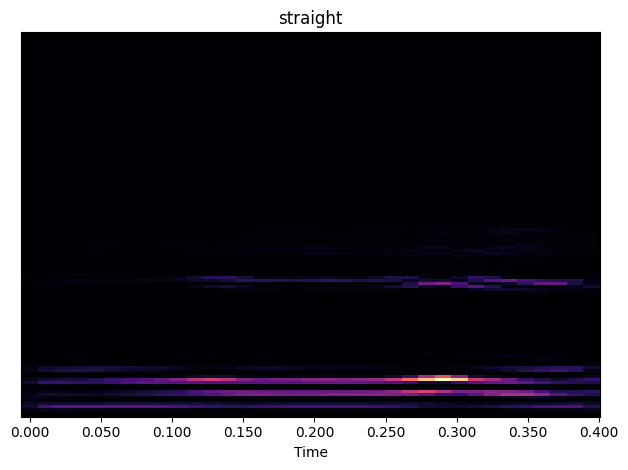

----------


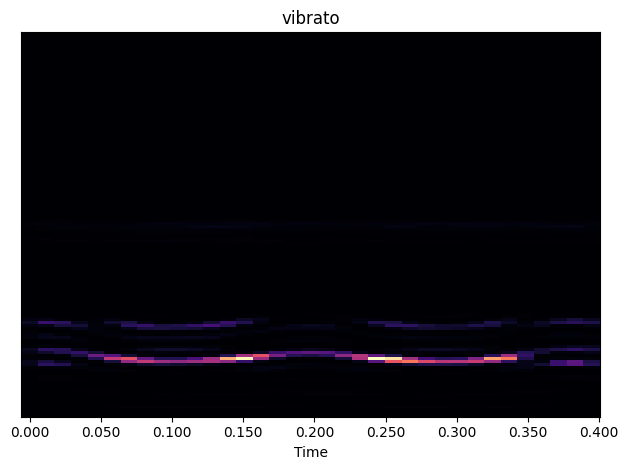

----------


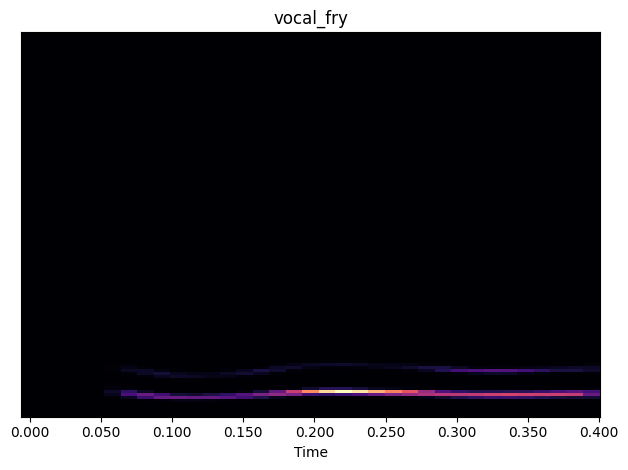

----------


In [ ]:
show_no_db_mel(technique_data, 0, ["belt","straight","vibrato",'vocal_fry'])

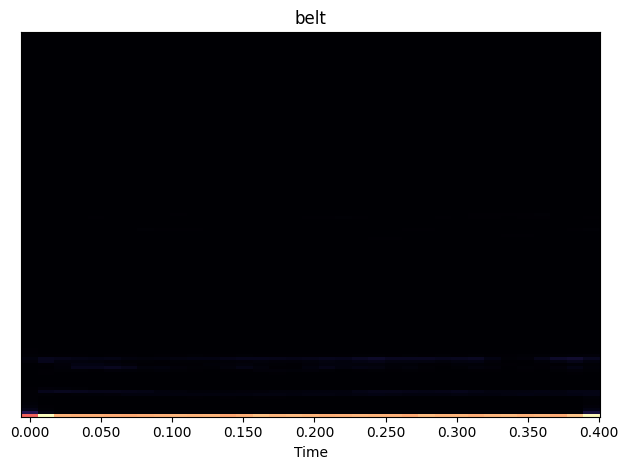

----------


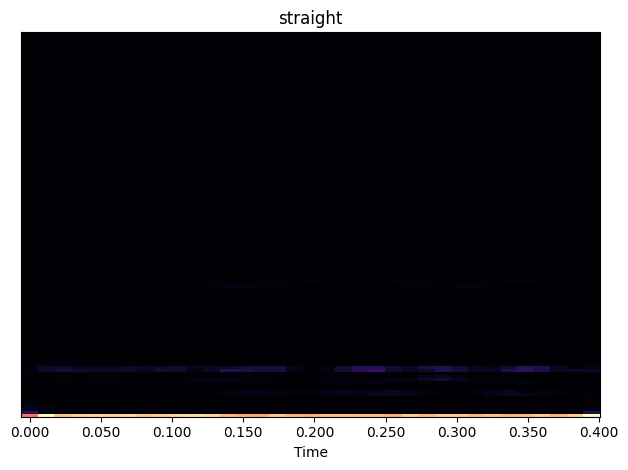

----------


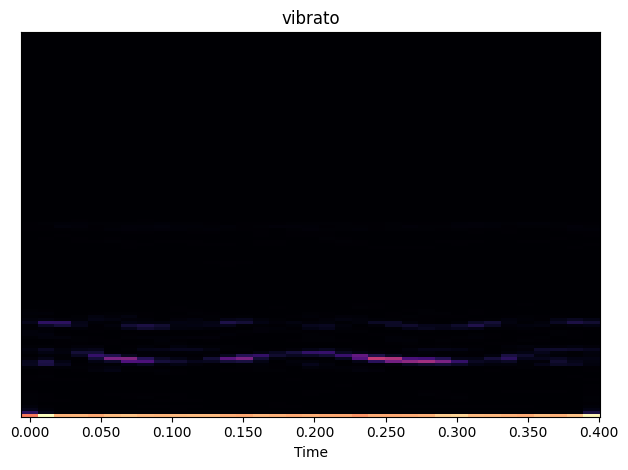

----------


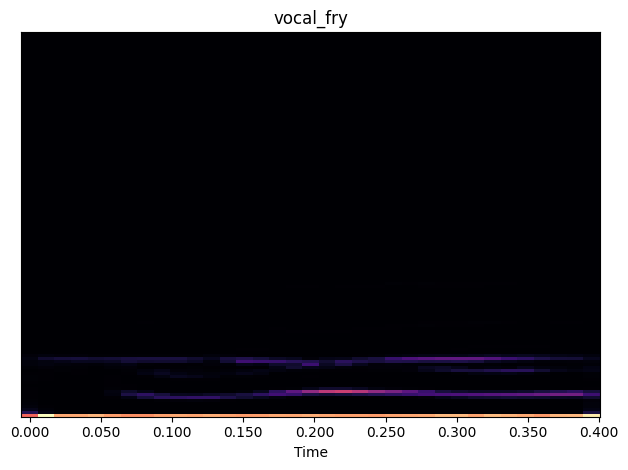

----------


In [ ]:
show_no_db_mel(std_data, 0, ["belt","straight","vibrato",'vocal_fry'])

In [ ]:
def show_magphase_no_db_mel(data, idx,name):
  for name_idx,i in enumerate(data):
    sgram_mag, _ = librosa.magphase(i[idx])
    ret = librosa.feature.melspectrogram(y = sgram_mag, sr = 44100)
    show_spec(data = ret, name = name[name_idx])
    print("-"*10)

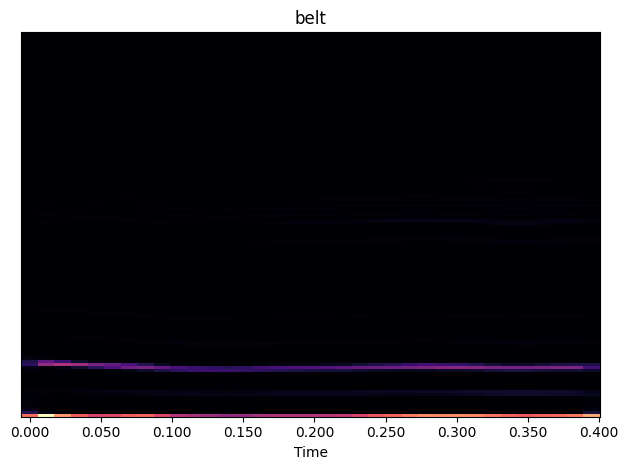

----------


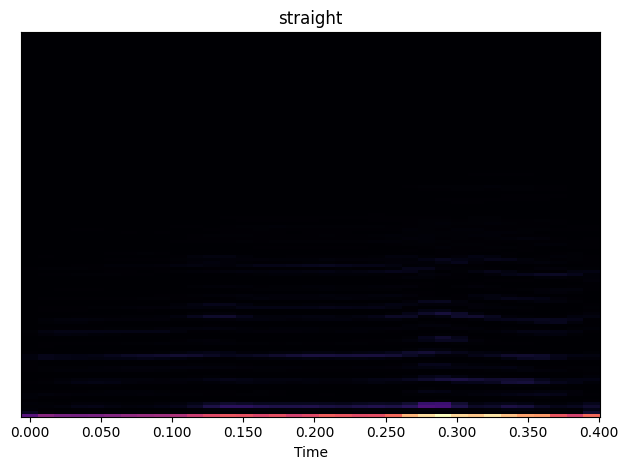

----------


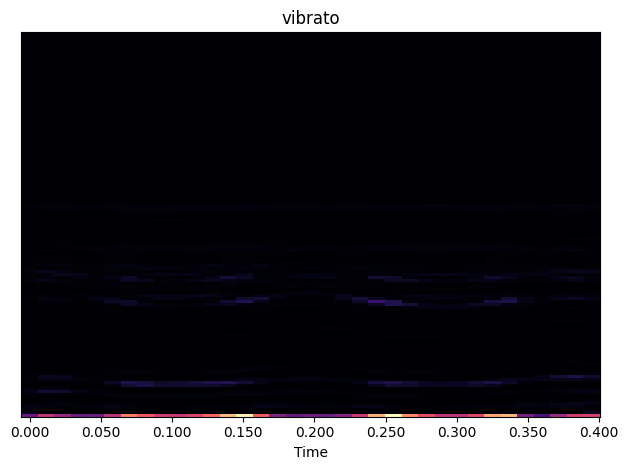

----------


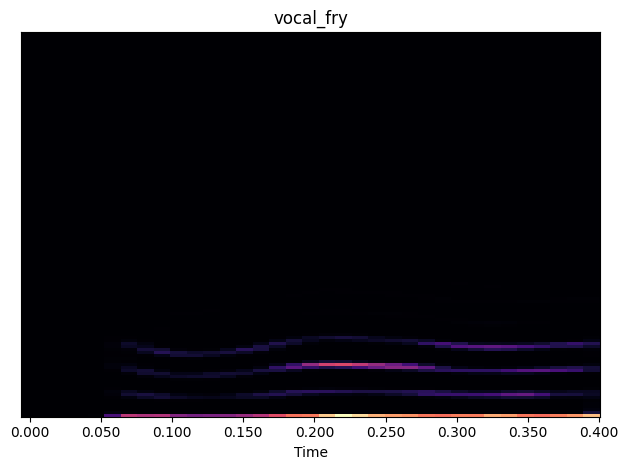

----------


In [ ]:
show_magphase_no_db_mel(technique_data, 0, ["belt","straight","vibrato",'vocal_fry'])

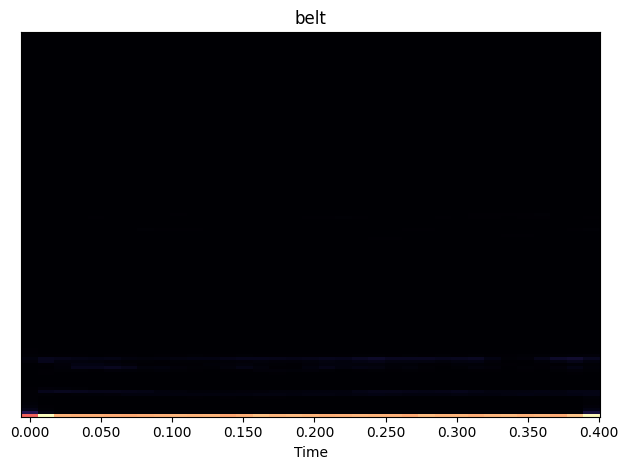

----------


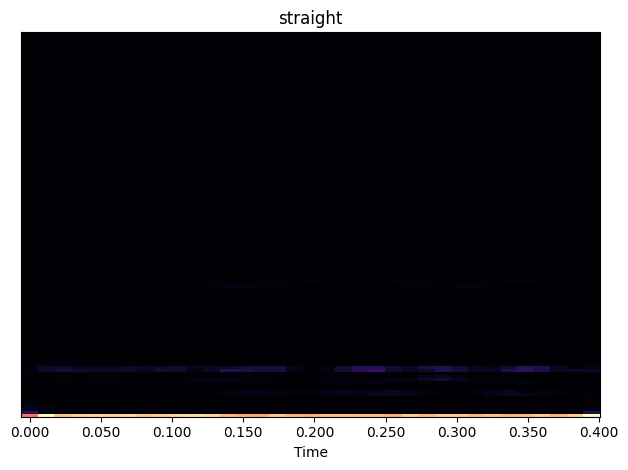

----------


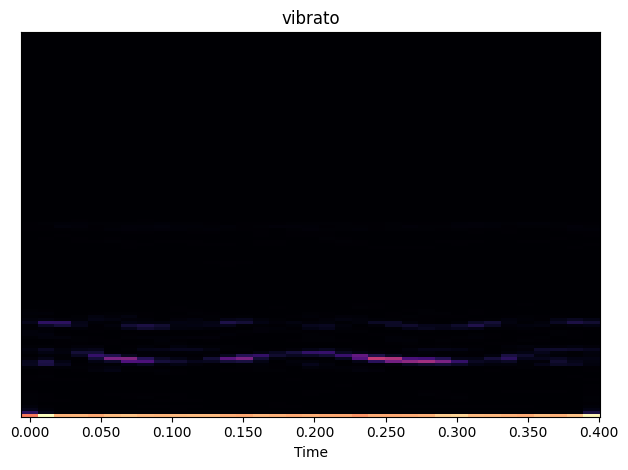

----------


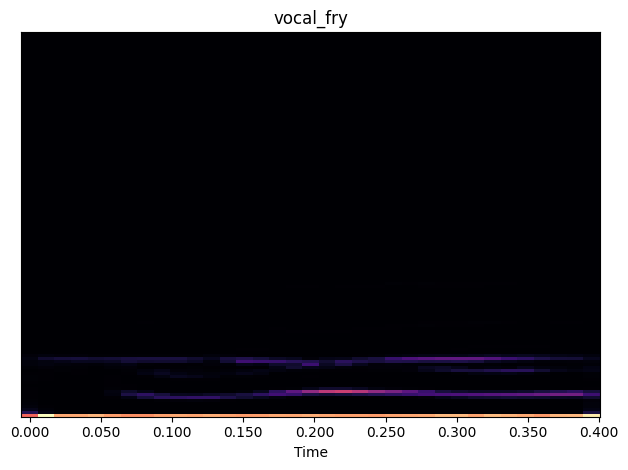

----------


In [ ]:
show_magphase_no_db_mel(std_data, 0, ["belt","straight","vibrato",'vocal_fry'])

# mfcc

In [ ]:
def show_mfcc(data, idx,name):
  for name_idx,i in enumerate(data):
    ret = librosa.feature.mfcc(y = i[idx], sr = 44100, n_mfcc=20)
    amp = librosa.amplitude_to_db(np.abs(ret))
    show_spec(data = amp, name = name[name_idx])
    print("-"*10)

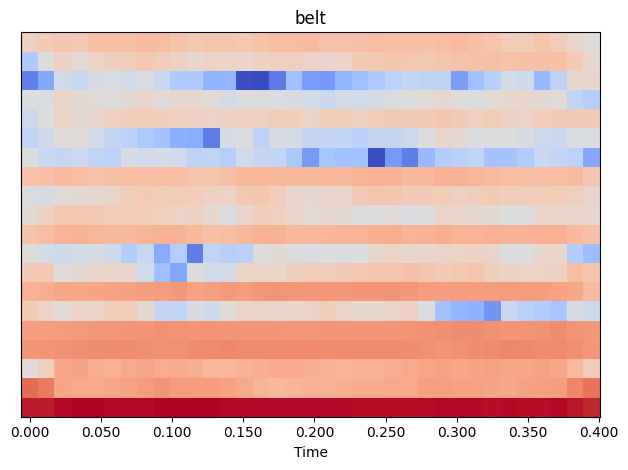

----------


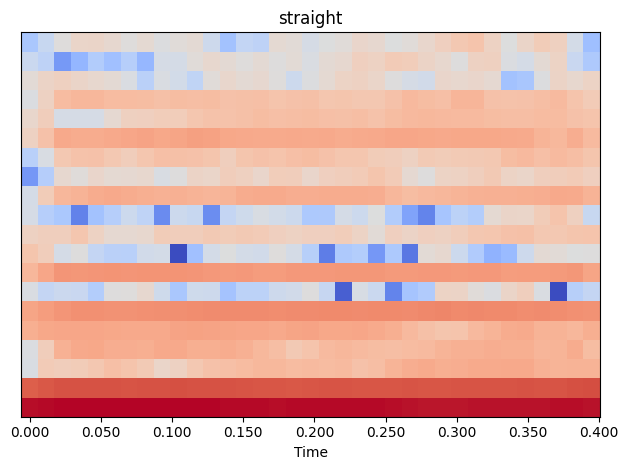

----------


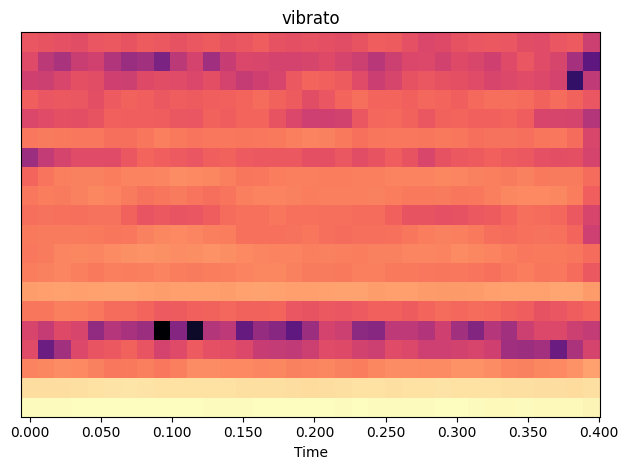

----------


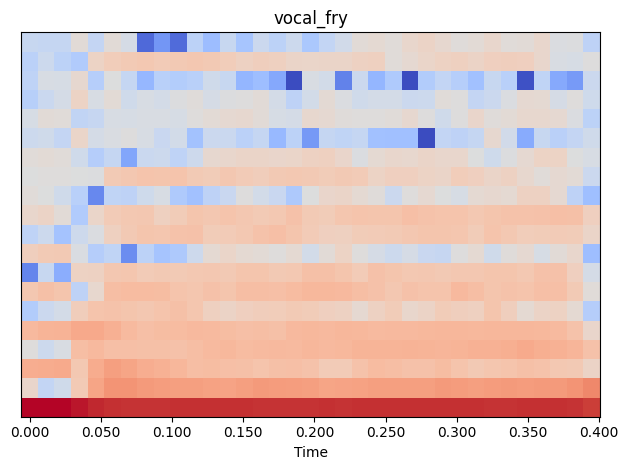

----------


In [ ]:
show_mfcc(technique_data, 0, ["belt","straight","vibrato",'vocal_fry'])

### 1) compare mfcc & standardized mfcc

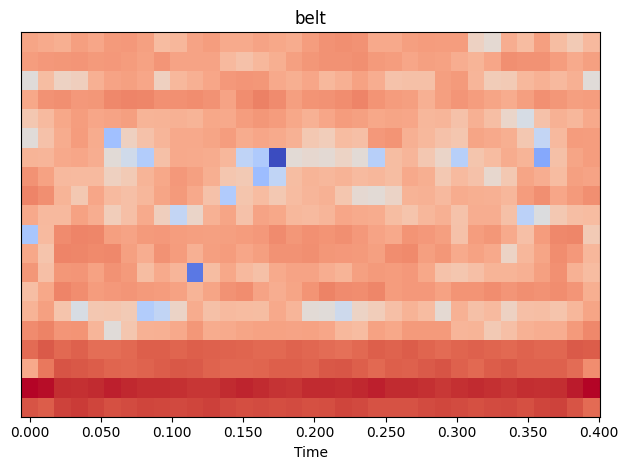

----------


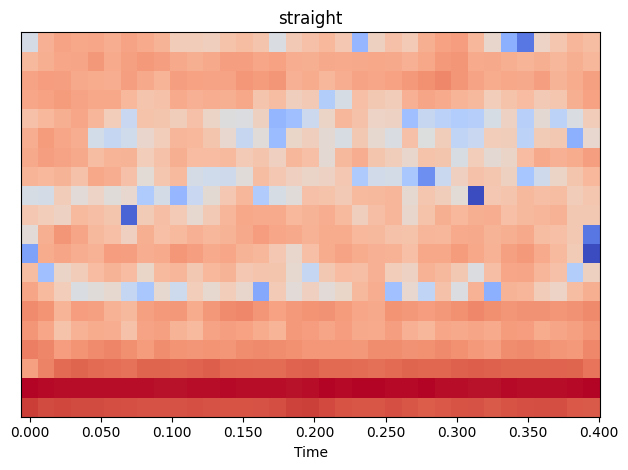

----------


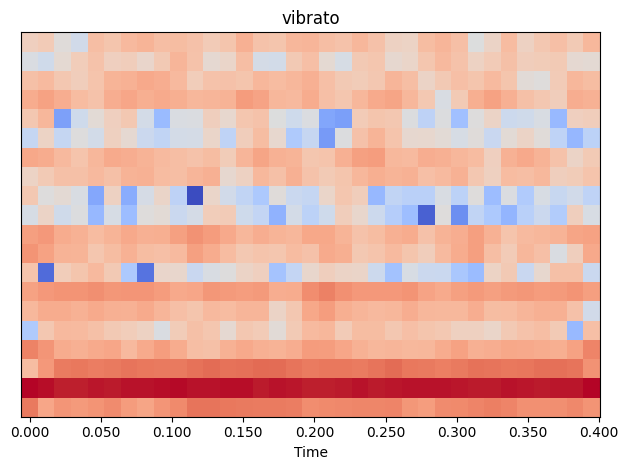

----------


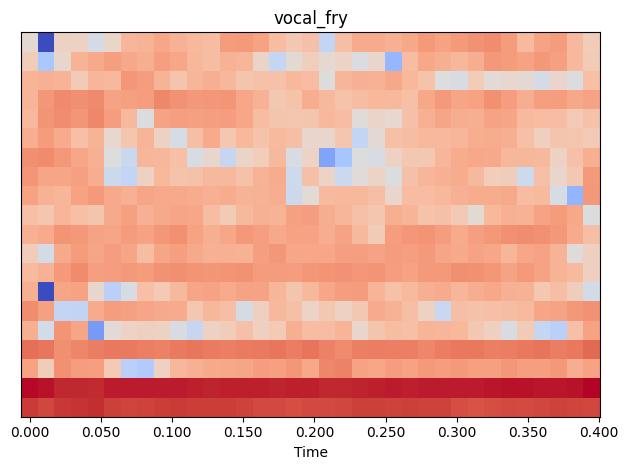

----------


In [ ]:
show_mfcc(std_data, 0, ["belt","straight","vibrato",'vocal_fry'])

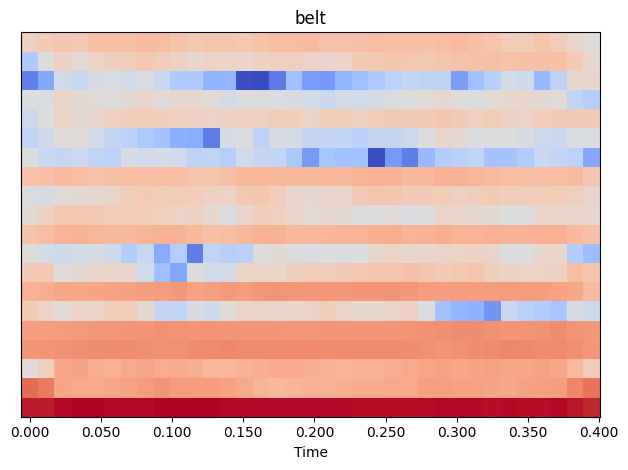

----------


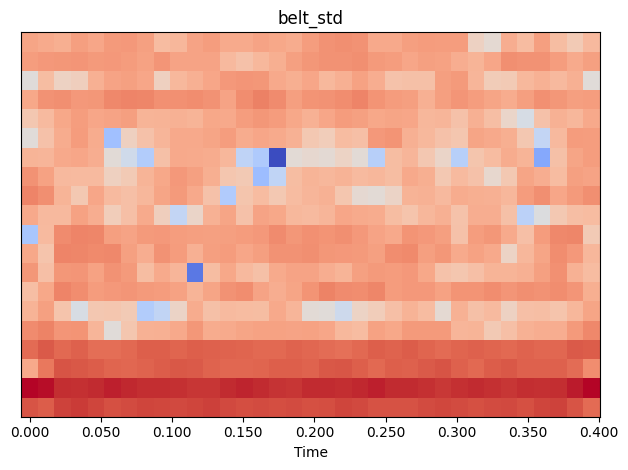

----------


In [ ]:
show_mfcc([belt_audio, belt_std], 0, ["belt", "belt_std"])

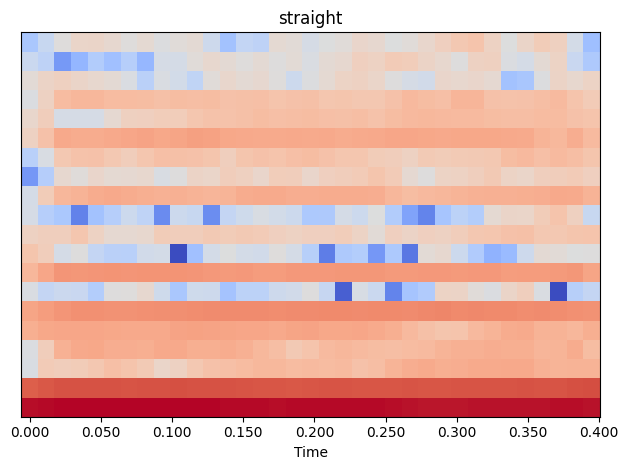

----------


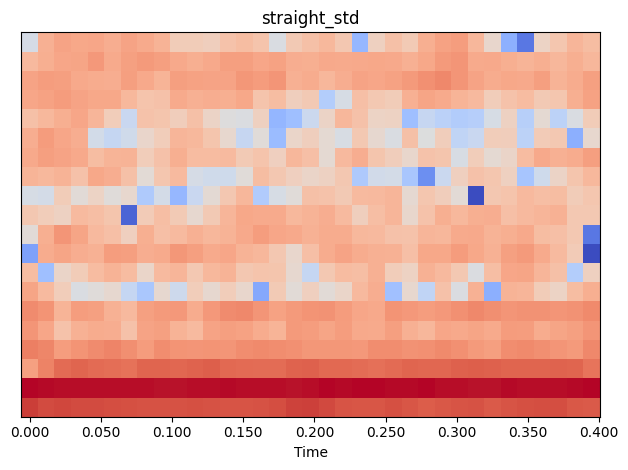

----------


In [ ]:
show_mfcc([straight_audio, straight_std], 0, ["straight", "straight_std"])

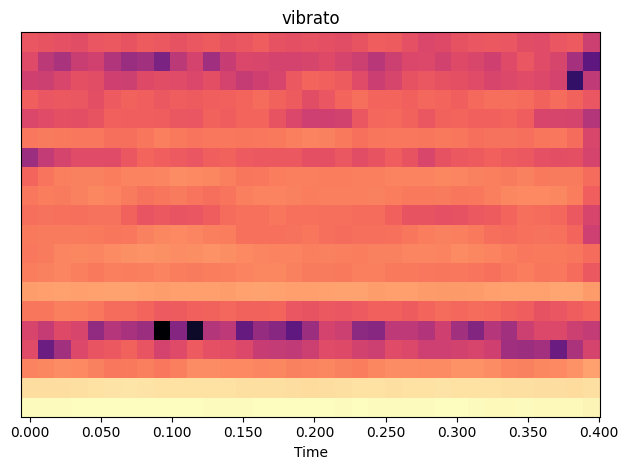

----------


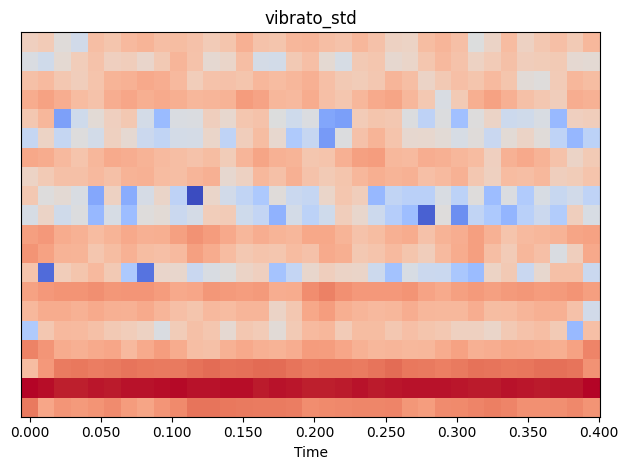

----------


In [ ]:
show_mfcc([vibrato_audio, vibrato_std], 0, ["vibrato", "vibrato_std"])

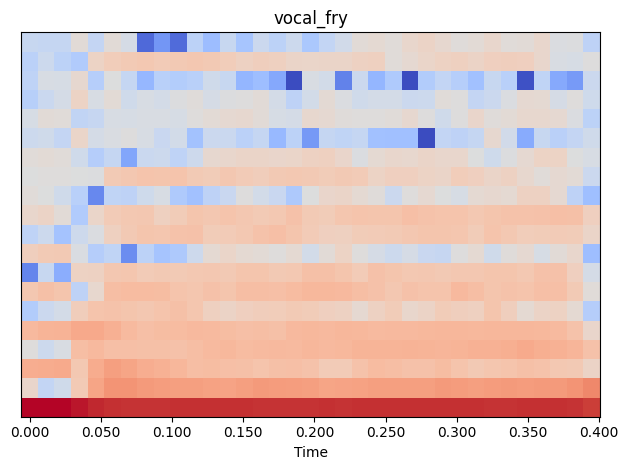

----------


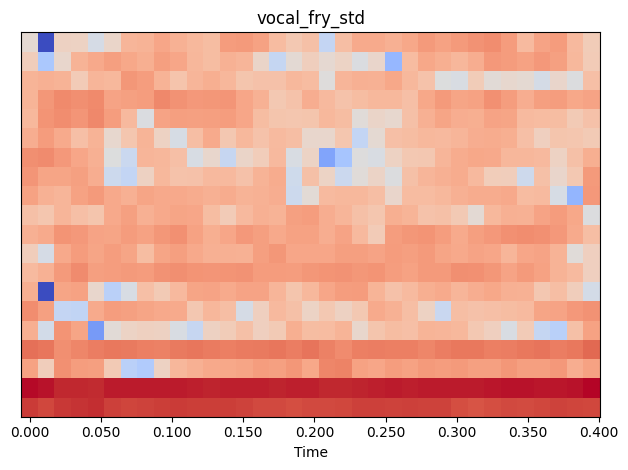

----------


In [ ]:
show_mfcc([vocal_fry_audio, vocal_fry_std], 0, ["vocal_fry", "vocal_fry_std"])

### 2) belt + augmented

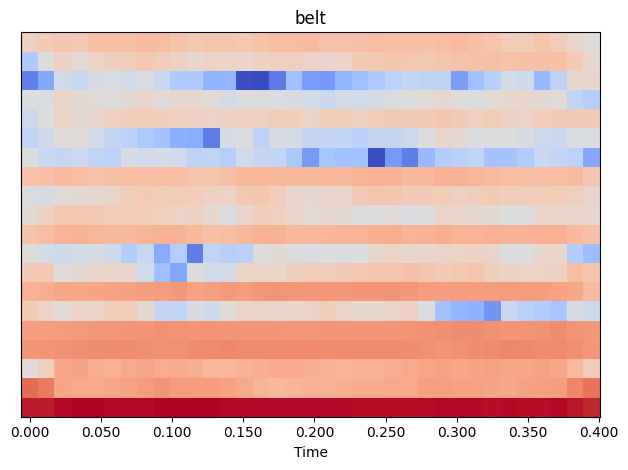

----------


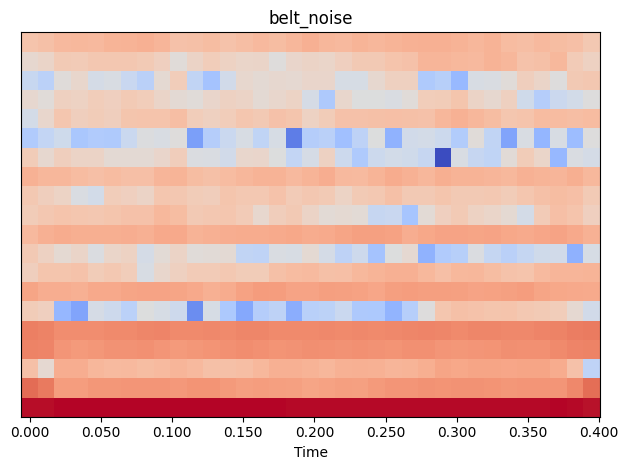

----------


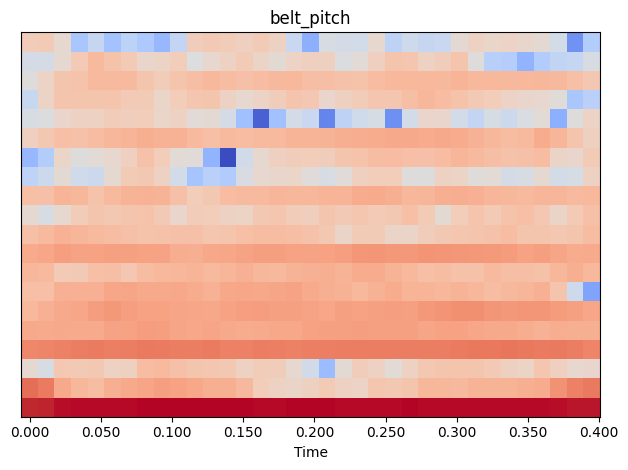

----------


In [ ]:
show_mfcc(belt_data,0, name=["belt", "belt_noise", "belt_pitch"])

### 3) straight + augmented

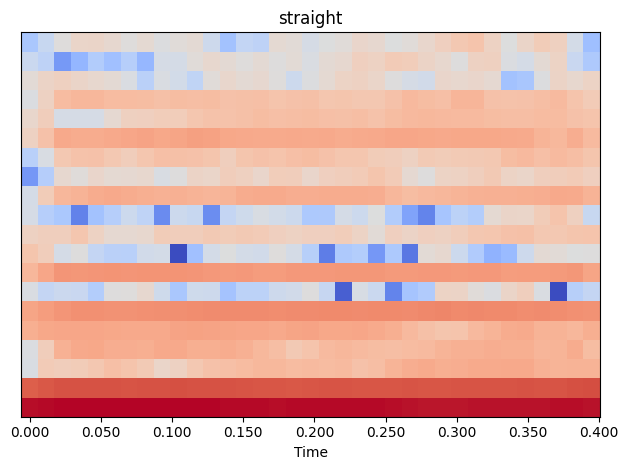

----------


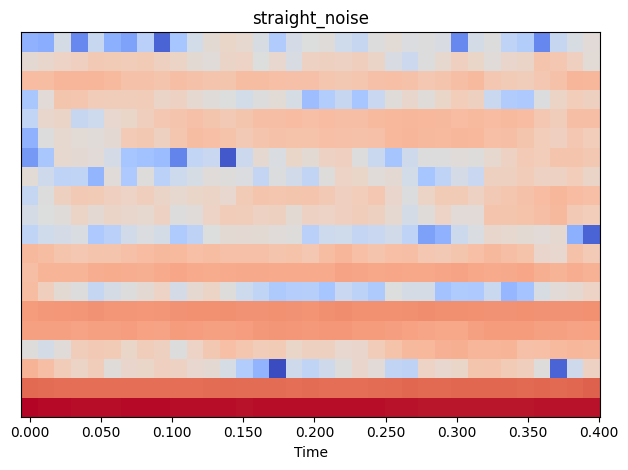

----------


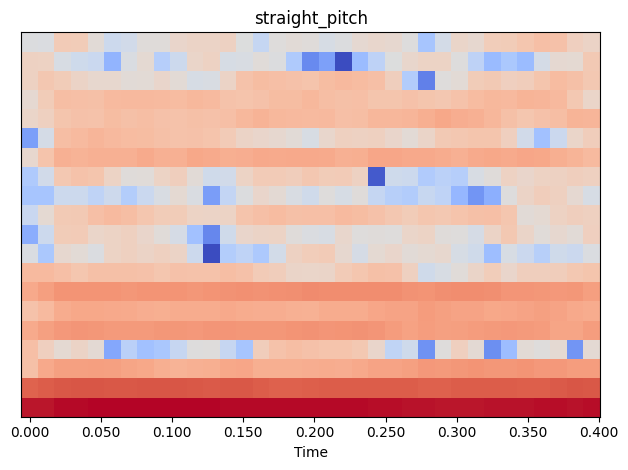

----------


In [ ]:
show_mfcc(straight_data,0, name=["straight", "straight_noise", "straight_pitch"])

### 4) vibrato + augmented

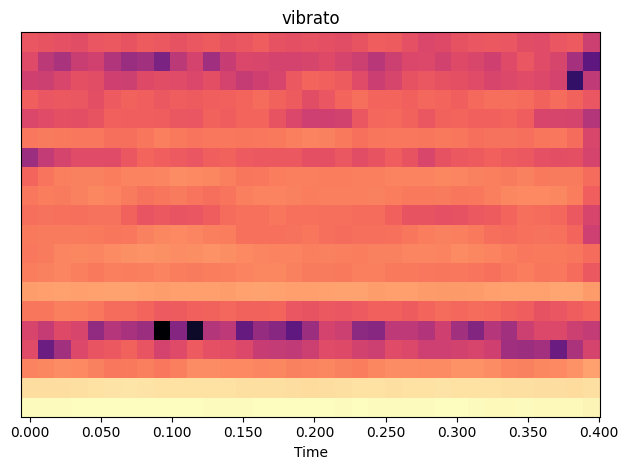

----------


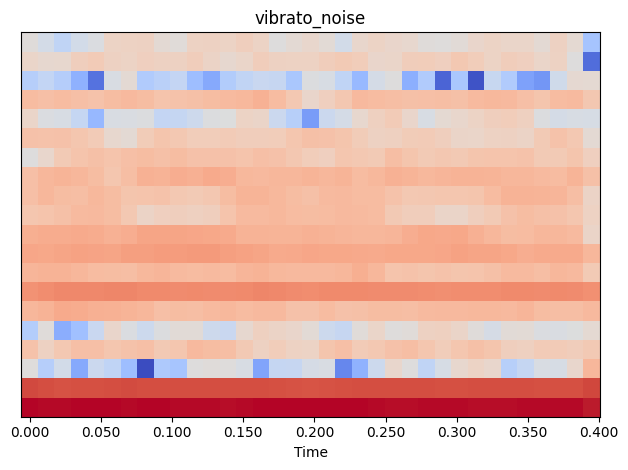

----------


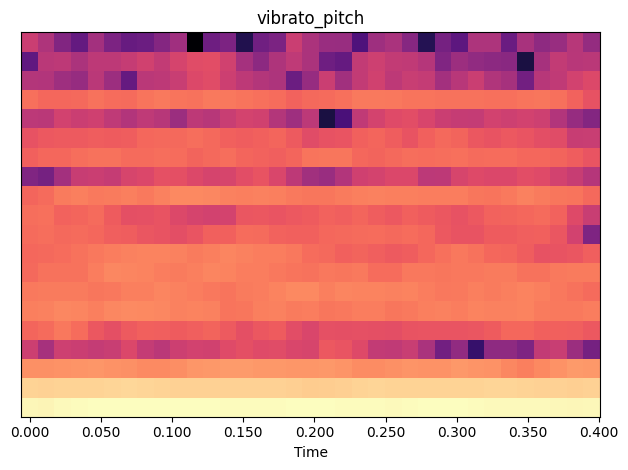

----------


In [ ]:
show_mfcc(vibrato_data,0, name=["vibrato", "vibrato_noise", "vibrato_pitch"])

### 5) vocal_fry + augmented

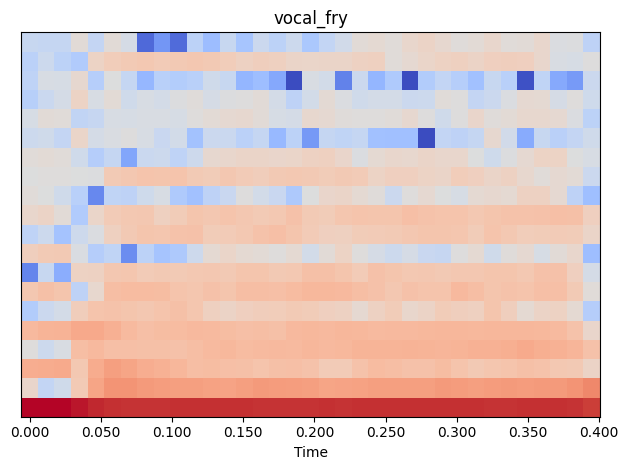

----------


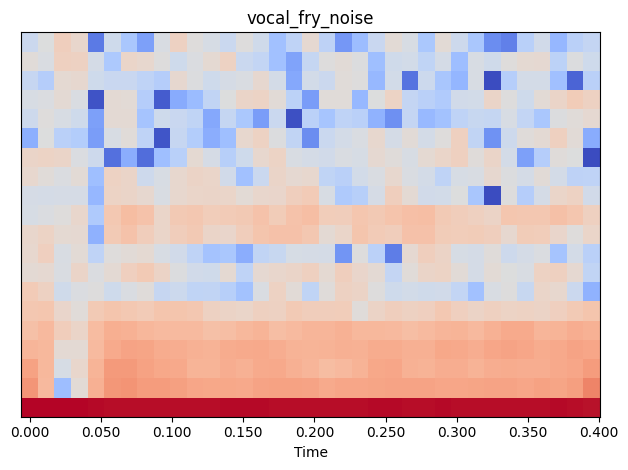

----------


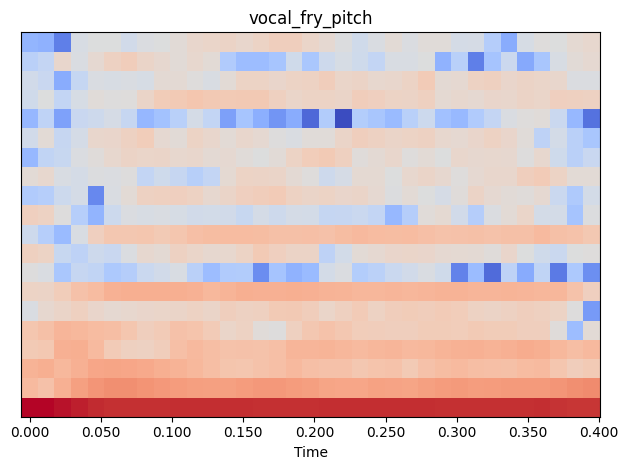

----------


In [ ]:
show_mfcc(vocal_fry_data,0, name=["vocal_fry", "vocal_fry_noise", "vocal_fry_pitch"])